In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
import utils
#import paint_auth as pa
from lxml import etree as ET
from collections import Counter

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#import all xml and convert to pd dataframe
#only extract painters
path = './data/chinese/'

info = pd.read_csv('./ch_info.csv')
file_names = list(info['file_name'])
file_names = [path + n for n in file_names]
labels, label_map = utils.get_labels(info, 'genre')
num_classes = len(pd.unique(labels))

In [5]:
#processing training and val dataset
val_size = 0.2
val_i = int(len(file_names) * (1 - val_size))

train_file_names = file_names[:val_i]
train_labels = labels[:val_i]
val_file_names = file_names[val_i:]
val_labels = labels[val_i:]

In [6]:
print 'training size: %d' % len(train_labels)
print 'val size: %d' % len(val_labels)

training size: 136
val size: 34


In [7]:
BATCH_SIZE=32

#train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_file_names, train_labels))
#flip images with prob. 0.6
train_dataset = train_dataset.map(utils.preprocess_image_flip)
train_dataset = train_dataset.shuffle(10000)
batch_train_dataset = train_dataset.batch(BATCH_SIZE)

#val dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_file_names, val_labels))
val_dataset = val_dataset.map(utils.val_preprocess_image)
batch_val_dataset = val_dataset.batch(BATCH_SIZE)


In [8]:
#setting up iterator for dataset
iterator = tf.data.Iterator.from_structure(batch_train_dataset.output_types,
                                                   batch_train_dataset.output_shapes)
images, labels = iterator.get_next()

train_init_op = iterator.make_initializer(batch_train_dataset)
val_init_op = iterator.make_initializer(batch_val_dataset)

# Indicates whether we are in training or in test mode
is_training = tf.placeholder(tf.bool)

In [9]:
#setting up pretrained resnet trained on Imagenet
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
from inception_resnet_v2 import inception_resnet_v2, inception_resnet_v2_arg_scope

In [10]:
#tf.reset_default_graph()

In [11]:
#note graph init. should only be ran once, use above cell to reset graph to run more than once
with slim.arg_scope(inception_resnet_v2_arg_scope()): #default parameter
    output, _ = inception_resnet_v2(images, num_classes=num_classes, is_training=is_training) #initialize model
    output = tf.nn.softmax(output)

In [12]:
#loading from checkpoint
ckpt_path = './checkpoint/inception_resnet_v2_2016_08_30.ckpt'
#exclude output layer as it has different class size
variables_to_restore = tf.contrib.framework.get_variables_to_restore(exclude=['InceptionResnetV2/Logits', 'InceptionResnetV2/AuxLogits'])
init_fn = tf.contrib.framework.assign_from_checkpoint_fn(ckpt_path, variables_to_restore) #call to load weights

In [13]:
#define new logits variables
logits_variables = tf.contrib.framework.get_variables('InceptionResnetV2/Logits')
logits_init = tf.variables_initializer(logits_variables)
auxlogits_variables = tf.contrib.framework.get_variables('InceptionResnetV2/AuxLogits')
auxlogits_init = tf.variables_initializer(auxlogits_variables)

In [14]:
#define optimizers and loss
#optimizers initialized multiple times for each specific set of weights
alpha = 5e-4
alpha2 = 5e-6
one_hot_labels = tf.one_hot(labels, num_classes)
tf.losses.softmax_cross_entropy(one_hot_labels, output) #allows easy access for loss from tf.GraphKeys.losses
loss = tf.losses.get_total_loss()

logit_optimizer = tf.train.GradientDescentOptimizer(alpha)
auxlogit_optimizer = tf.train.GradientDescentOptimizer(alpha)

#train only logis/auxlogis variables
logit_train_op = logit_optimizer.minimize(loss, var_list=logits_variables)
auxlogit_train_op = auxlogit_optimizer.minimize(loss, var_list=auxlogits_variables)

#train all weights using same optimizer
full_optimizer = tf.train.GradientDescentOptimizer(alpha2)
full_train_op = full_optimizer.minimize(loss)

In [15]:
# #evals
predictions = tf.to_int32(tf.argmax(output, 1))
correct_predictions = tf.equal(predictions, labels)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [16]:
# #evals
# predictions = tf.to_int32(tf.argmax(output, 1))
# accuracy = tf.reduce_mean(tf.cast((predictions - labels) == 0,tf.int32))

In [17]:
#graph read only
# tf.get_default_graph().finalize()

In [18]:
# def check_accuracy(sess, accuracy, is_training, dataset_train_op):
#     sess.run(dataset_train_op)
#     total_acc = 0
#     while True: #run while non-empty iterator
#         try:
#             acc = sess.run(accuracy, {is_training:False})
#             print acc
#             total_acc += acc
#         except tf.errors.OutOfRangeError:
#             break
        
#     return np.mean(total_acc)

In [19]:
# def get_accuracy(sess, predictions, labels, is_training, dataset_train_op):
#     sess.run(dataset_train_op)
#     total_acc = []
#     while True:
#         try:
# #             pred = sess.run(predictions, {is_training:False})
#             pred = np.zeros(64)
#             my_labels = sess.run(labels)
#             acc = np.mean(np.equal(my_labels, predictions))
            
#             print type(pred[0])
#             print type(my_labels[0])
#             print 'preds: '
#             print pred
#             print 'labels: '
#             print my_labels
#             print 'match: '
#             print np.equal(my_labels, predictions)
#             print 'acc: '
#             print acc
#             total_acc.append(acc)
#         except tf.errors.OutOfRangeError:
#             break
#     return np.mean(total_acc)

In [20]:
def get_predictions(sess, predictions, labels, is_training, dataset_train_op):
    sess.run(dataset_train_op)
    my_predictions = []
    my_labels = []
    my_logits = []
    while True:
        try:
            my_predictions.append(sess.run(predictions, {is_training:False}))
            my_labels.append(sess.run(labels))
            logits = sess.run(output, {is_training:False})
            print "logits: "
            print len(logits)
        except tf.errors.OutOfRangeError:
            break
    
    return my_predictions, my_labels
        
            

In [24]:
def print_outputs(sess, output, labels, is_training, dataset_train_op):
    sess.run(dataset_train_op)
    while True:
        try:
            logits = sess.run(output, {is_training: False})
            print 'output: '
            print logits
            print 'labels: '
            print sess.run(labels)
        except tf.errors.OutOfRangeError:
            break
    

In [22]:
def check_accuracy(sess, correct_prediction, is_training, dataset_init_op):
    """
    Check the accuracy of the model on either train or val (depending on dataset_init_op).
    """
    # Initialize the correct dataset
    sess.run(dataset_init_op)
    num_correct, num_samples = 0, 0
    while True:
        try:
            correct_pred = sess.run(correct_prediction, {is_training: False})
            num_correct += correct_pred.sum()
            num_samples += correct_pred.shape[0]
        except tf.errors.OutOfRangeError:
            break

    # Return the fraction of datapoints that were correctly classified
    acc = float(num_correct) / num_samples
    return acc

INFO:tensorflow:Restoring parameters from ./checkpoint/inception_resnet_v2_2016_08_30.ckpt
Starting epoch: 1 / 10000
training... done
Train Acc.: 0.294118
Val. Acc.: 0.205882


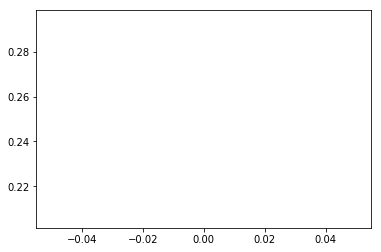

Starting epoch: 2 / 10000
training... done
Train Acc.: 0.250000
Val. Acc.: 0.147059


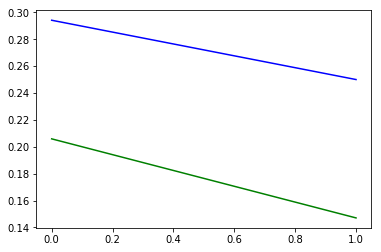

Starting epoch: 3 / 10000
training... done
Train Acc.: 0.286765
Val. Acc.: 0.147059


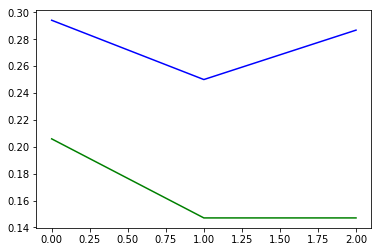

Starting epoch: 4 / 10000
training... done
Train Acc.: 0.272059
Val. Acc.: 0.147059


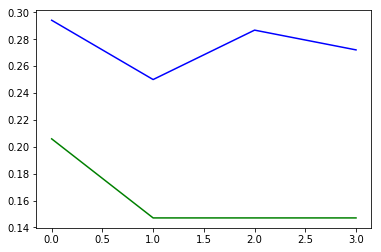

Starting epoch: 5 / 10000
training... done
Train Acc.: 0.272059
Val. Acc.: 0.147059


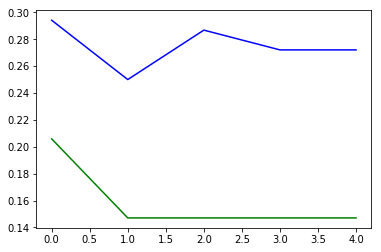

Starting epoch: 6 / 10000
training... done
Train Acc.: 0.264706
Val. Acc.: 0.147059


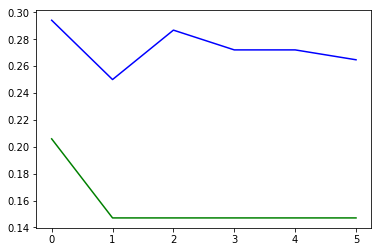

Starting epoch: 7 / 10000
training... done
Train Acc.: 0.264706
Val. Acc.: 0.147059


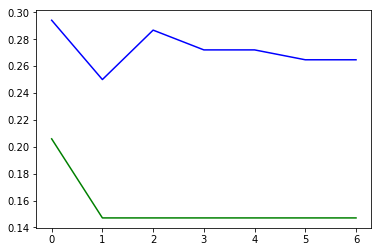

Starting epoch: 8 / 10000
training... done
Train Acc.: 0.308824
Val. Acc.: 0.147059


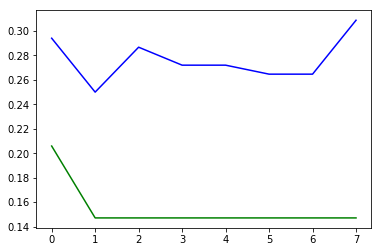

Starting epoch: 9 / 10000
training... done
Train Acc.: 0.294118
Val. Acc.: 0.147059


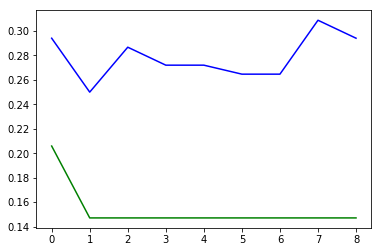

Starting epoch: 10 / 10000
training... done
Train Acc.: 0.301471
Val. Acc.: 0.147059


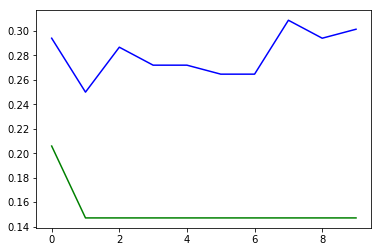

Starting epoch: 11 / 10000
training... done
Train Acc.: 0.286765
Val. Acc.: 0.147059


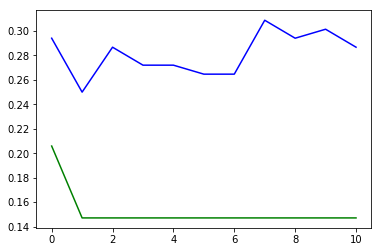

Starting epoch: 12 / 10000
training... done
Train Acc.: 0.301471
Val. Acc.: 0.147059


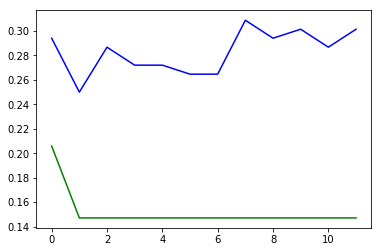

Starting epoch: 13 / 10000
training... done
Train Acc.: 0.279412
Val. Acc.: 0.058824


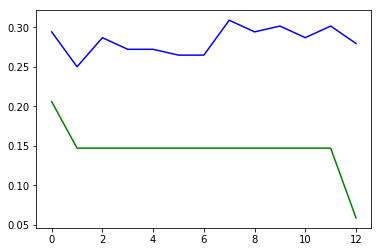

Starting epoch: 14 / 10000
training... done
Train Acc.: 0.286765
Val. Acc.: 0.029412


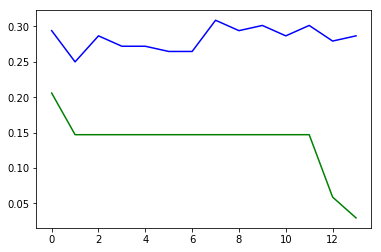

Starting epoch: 15 / 10000
training... done
Train Acc.: 0.316176
Val. Acc.: 0.029412


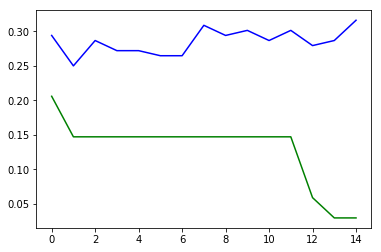

Starting epoch: 16 / 10000
training... done
Train Acc.: 0.316176
Val. Acc.: 0.029412


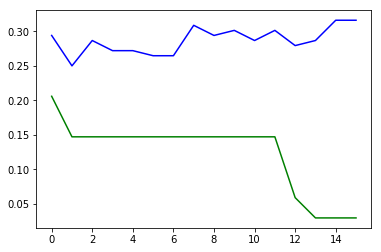

Starting epoch: 17 / 10000
training... done
Train Acc.: 0.294118
Val. Acc.: 0.029412


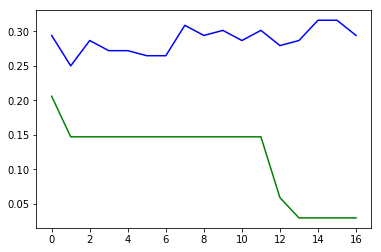

Starting epoch: 18 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.029412


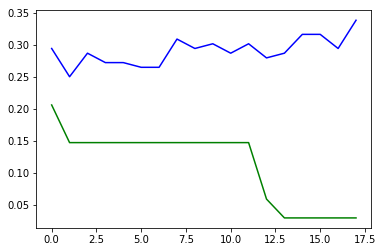

Starting epoch: 19 / 10000
training... done
Train Acc.: 0.294118
Val. Acc.: 0.000000


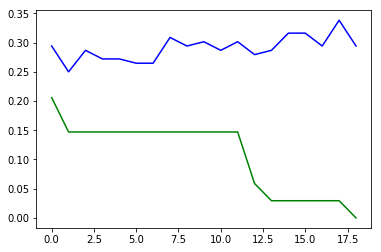

Starting epoch: 20 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


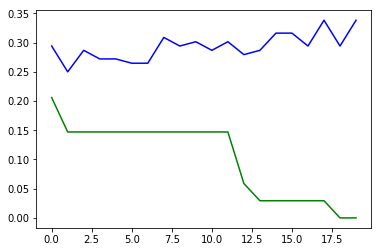

Starting epoch: 21 / 10000
training... done
Train Acc.: 0.330882
Val. Acc.: 0.000000


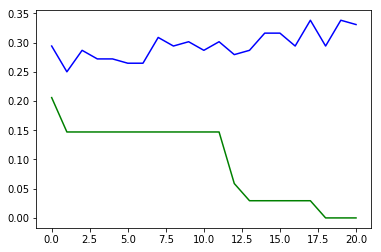

Starting epoch: 22 / 10000
training... done
Train Acc.: 0.323529
Val. Acc.: 0.000000


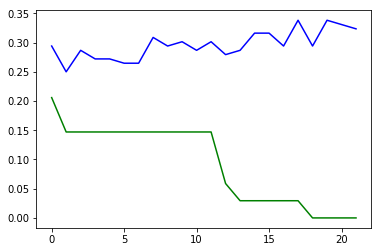

Starting epoch: 23 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


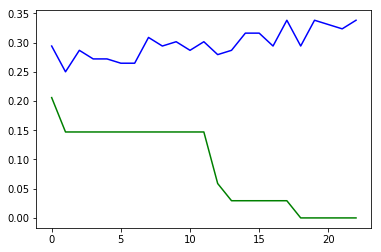

Starting epoch: 24 / 10000
training... done
Train Acc.: 0.301471
Val. Acc.: 0.000000


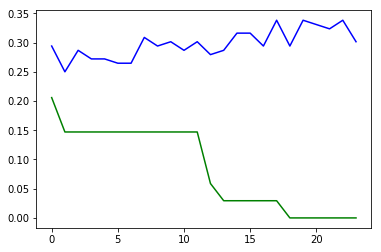

Starting epoch: 25 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


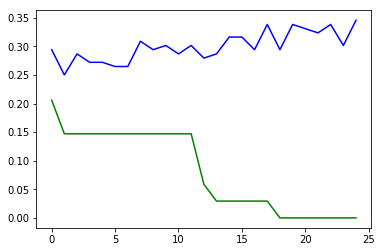

Starting epoch: 26 / 10000
training... done
Train Acc.: 0.294118
Val. Acc.: 0.000000


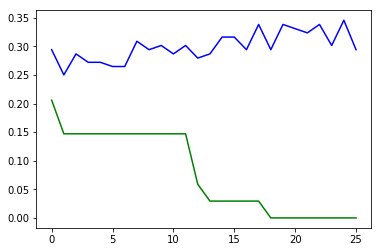

Starting epoch: 27 / 10000
training... done
Train Acc.: 0.316176
Val. Acc.: 0.000000


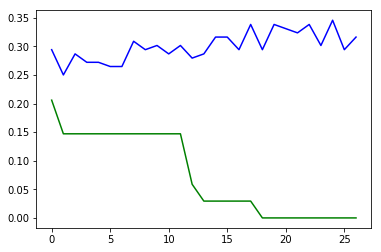

Starting epoch: 28 / 10000
training... done
Train Acc.: 0.323529
Val. Acc.: 0.000000


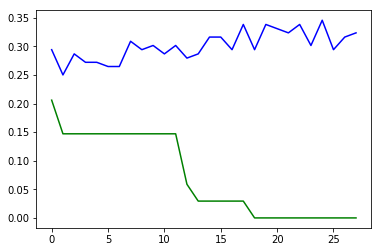

Starting epoch: 29 / 10000
training... done
Train Acc.: 0.323529
Val. Acc.: 0.000000


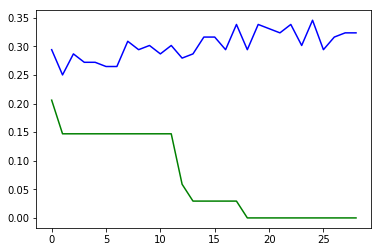

Starting epoch: 30 / 10000
training... done
Train Acc.: 0.316176
Val. Acc.: 0.000000


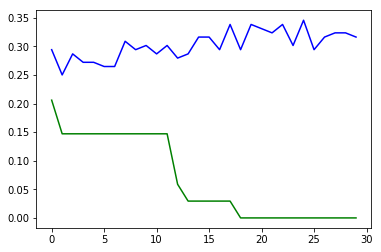

Starting epoch: 31 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


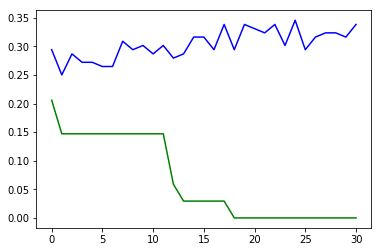

Starting epoch: 32 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


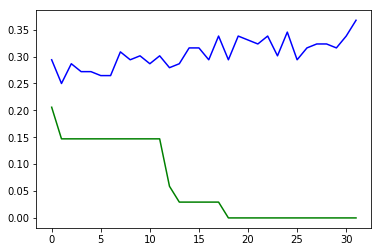

Starting epoch: 33 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


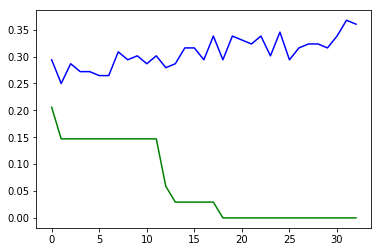

Starting epoch: 34 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


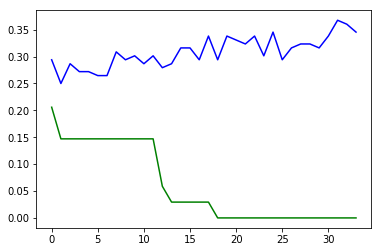

Starting epoch: 35 / 10000
training... done
Train Acc.: 0.323529
Val. Acc.: 0.000000


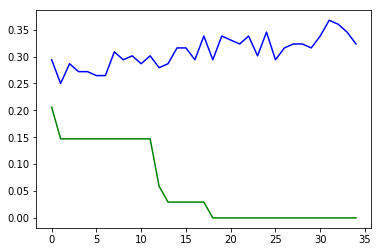

Starting epoch: 36 / 10000
training... done
Train Acc.: 0.330882
Val. Acc.: 0.000000


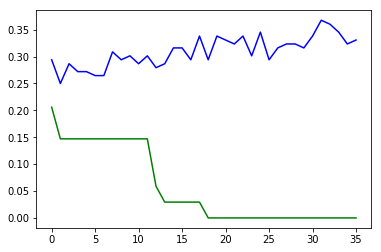

Starting epoch: 37 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


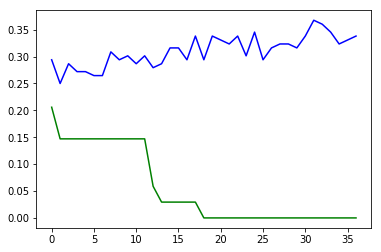

Starting epoch: 38 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


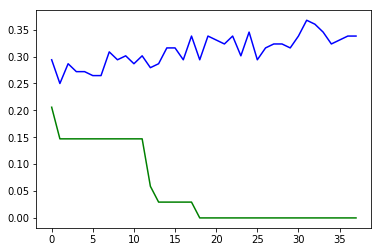

Starting epoch: 39 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


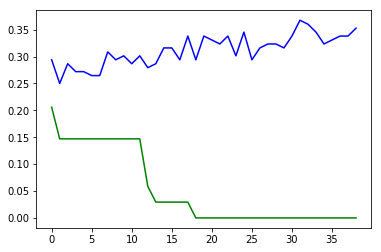

Starting epoch: 40 / 10000
training... done
Train Acc.: 0.330882
Val. Acc.: 0.000000


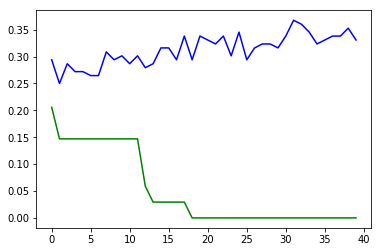

Starting epoch: 41 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


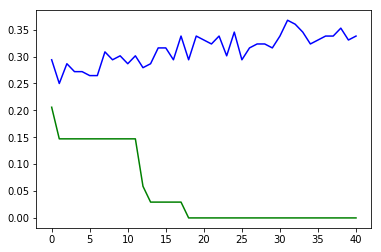

Starting epoch: 42 / 10000
training... done
Train Acc.: 0.330882
Val. Acc.: 0.000000


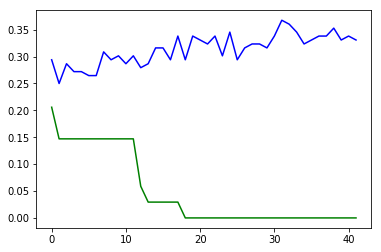

Starting epoch: 43 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


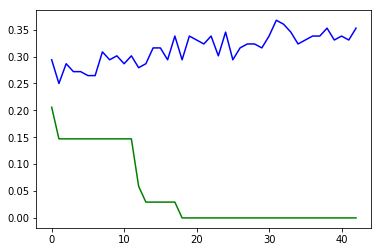

Starting epoch: 44 / 10000
training... done
Train Acc.: 0.323529
Val. Acc.: 0.000000


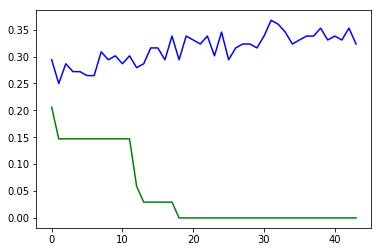

Starting epoch: 45 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


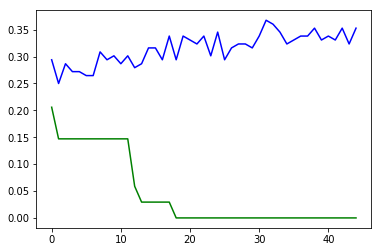

Starting epoch: 46 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


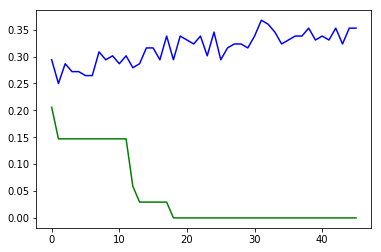

Starting epoch: 47 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


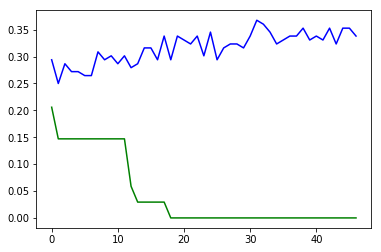

Starting epoch: 48 / 10000
training... done
Train Acc.: 0.301471
Val. Acc.: 0.000000


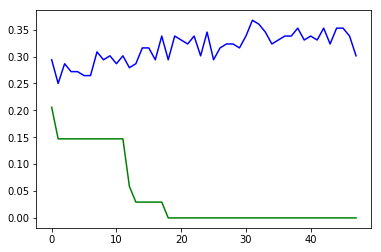

Starting epoch: 49 / 10000
training... done
Train Acc.: 0.316176
Val. Acc.: 0.000000


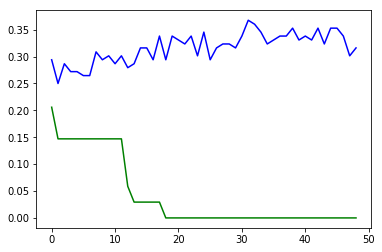

Starting epoch: 50 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


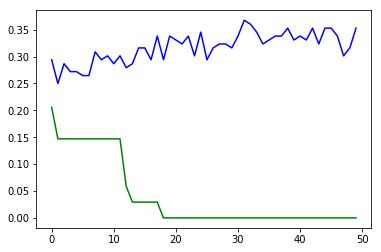

Starting epoch: 51 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


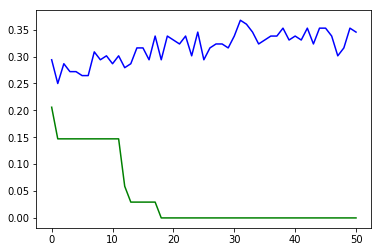

Starting epoch: 52 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


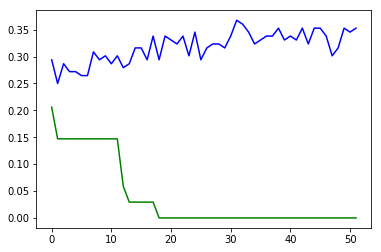

Starting epoch: 53 / 10000
training... done
Train Acc.: 0.308824
Val. Acc.: 0.000000


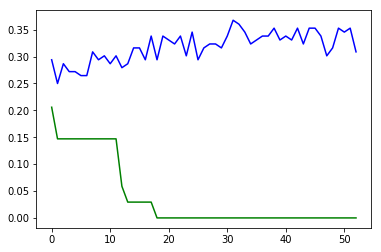

Starting epoch: 54 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


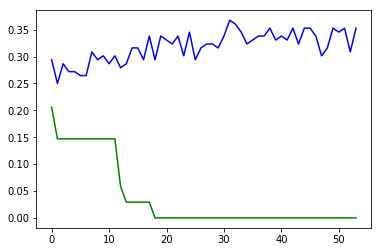

Starting epoch: 55 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


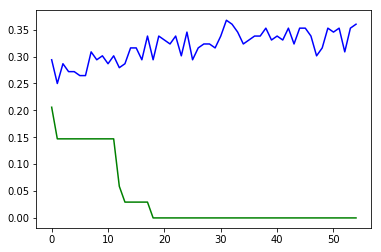

Starting epoch: 56 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


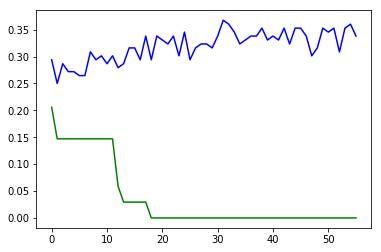

Starting epoch: 57 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


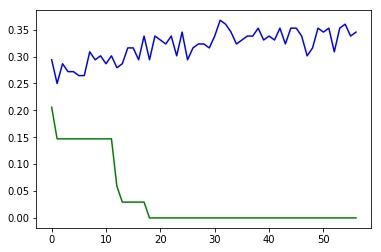

Starting epoch: 58 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


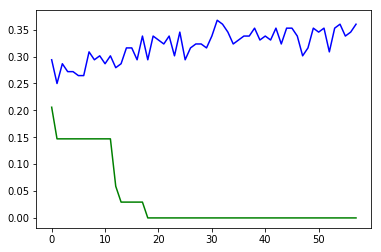

Starting epoch: 59 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


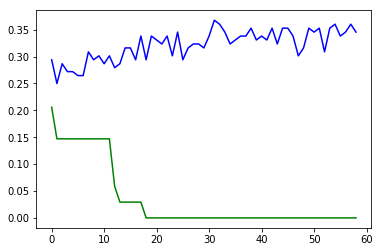

Starting epoch: 60 / 10000
training... done
Train Acc.: 0.323529
Val. Acc.: 0.000000


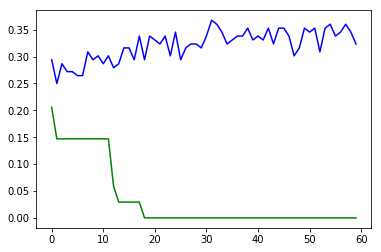

Starting epoch: 61 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


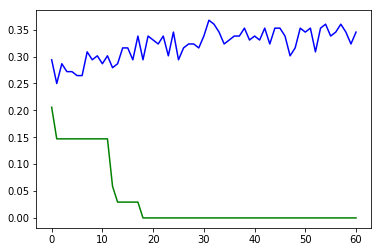

Starting epoch: 62 / 10000
training... done
Train Acc.: 0.330882
Val. Acc.: 0.000000


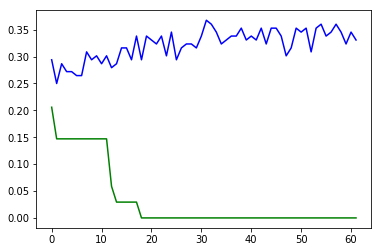

Starting epoch: 63 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


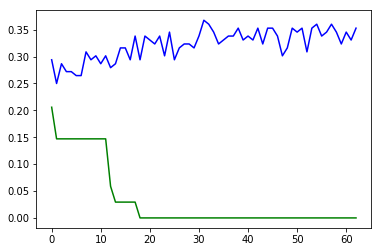

Starting epoch: 64 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


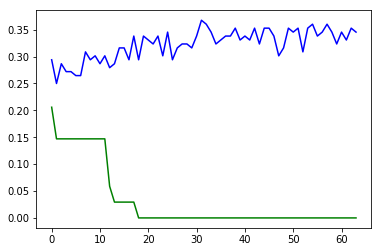

Starting epoch: 65 / 10000
training... done
Train Acc.: 0.330882
Val. Acc.: 0.000000


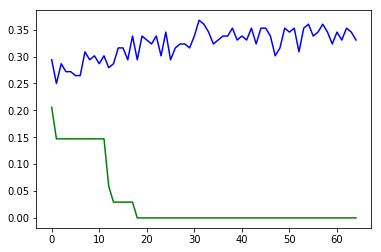

Starting epoch: 66 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


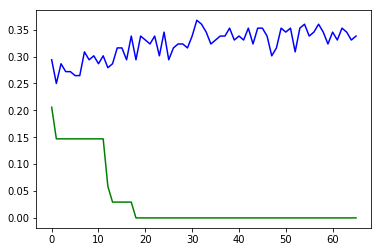

Starting epoch: 67 / 10000
training... done
Train Acc.: 0.330882
Val. Acc.: 0.000000


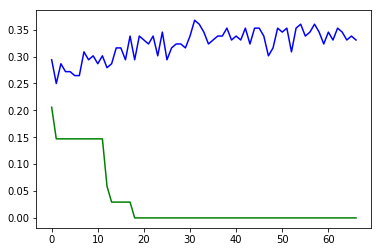

Starting epoch: 68 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


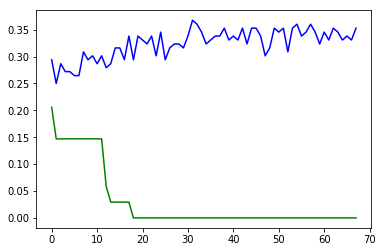

Starting epoch: 69 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


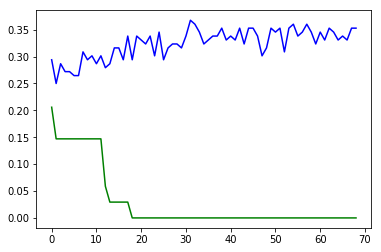

Starting epoch: 70 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


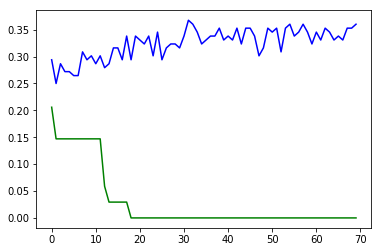

Starting epoch: 71 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


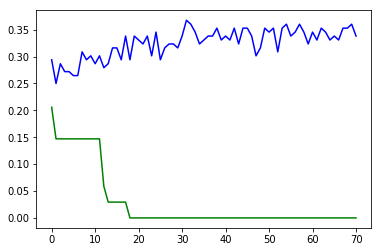

Starting epoch: 72 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


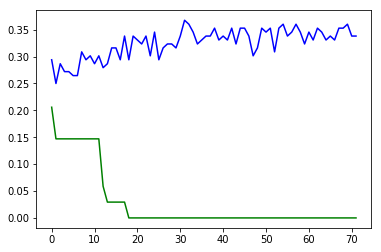

Starting epoch: 73 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


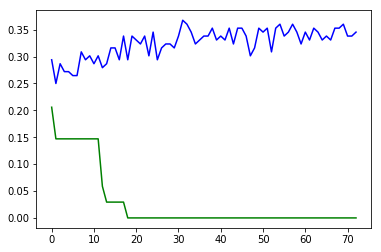

Starting epoch: 74 / 10000
training... done
Train Acc.: 0.323529
Val. Acc.: 0.000000


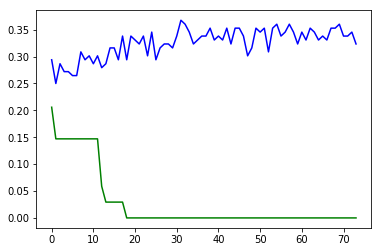

Starting epoch: 75 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


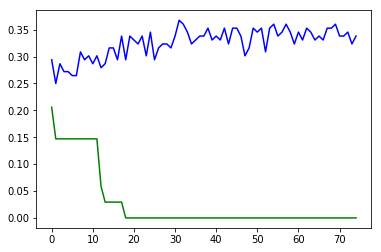

Starting epoch: 76 / 10000
training... done
Train Acc.: 0.389706
Val. Acc.: 0.000000


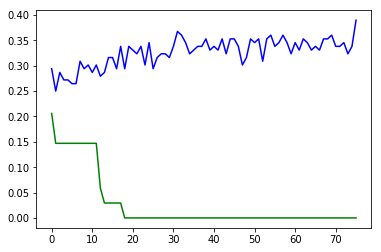

Starting epoch: 77 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


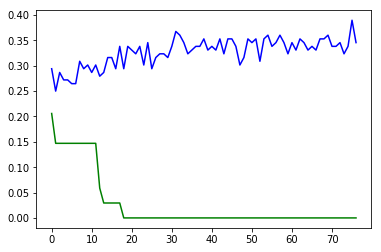

Starting epoch: 78 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


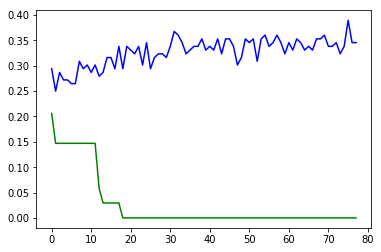

Starting epoch: 79 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


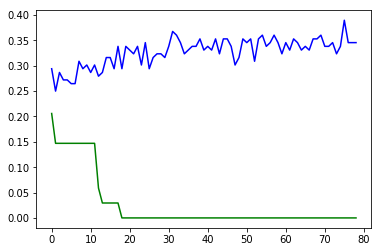

Starting epoch: 80 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


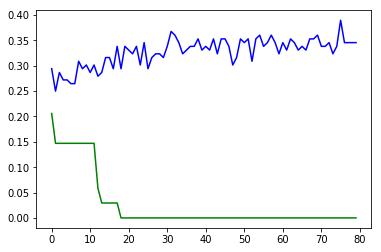

Starting epoch: 81 / 10000
training... done
Train Acc.: 0.330882
Val. Acc.: 0.000000


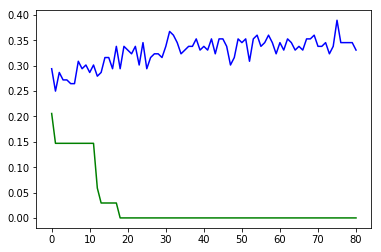

Starting epoch: 82 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


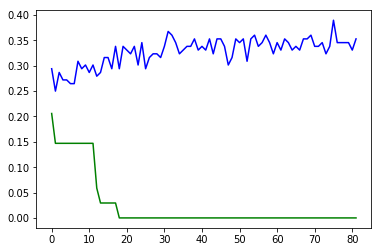

Starting epoch: 83 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


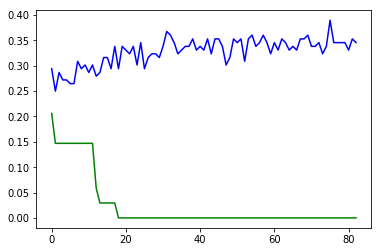

Starting epoch: 84 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


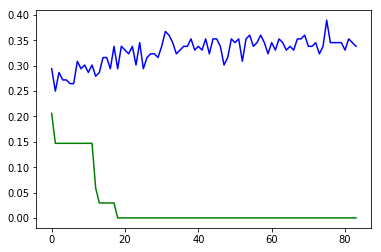

Starting epoch: 85 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


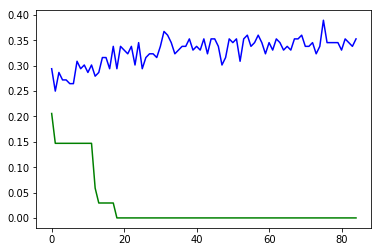

Starting epoch: 86 / 10000
training... done
Train Acc.: 0.323529
Val. Acc.: 0.000000


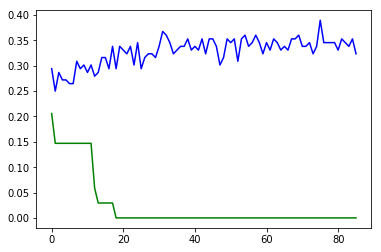

Starting epoch: 87 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


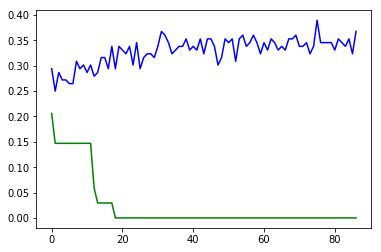

Starting epoch: 88 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


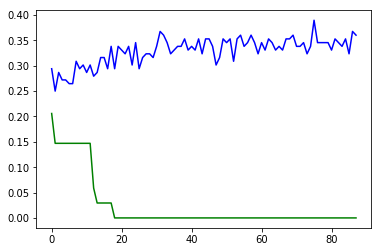

Starting epoch: 89 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


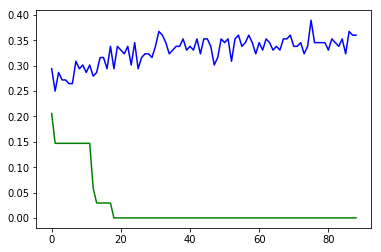

Starting epoch: 90 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


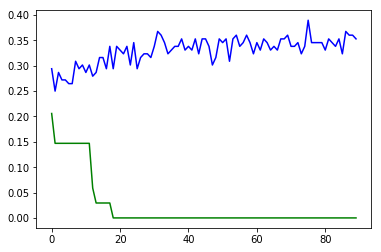

Starting epoch: 91 / 10000
training... done
Train Acc.: 0.323529
Val. Acc.: 0.000000


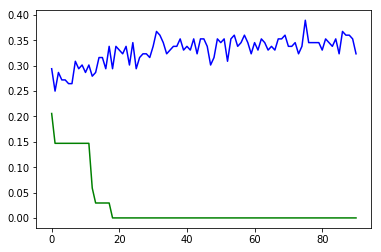

Starting epoch: 92 / 10000
training... done
Train Acc.: 0.330882
Val. Acc.: 0.000000


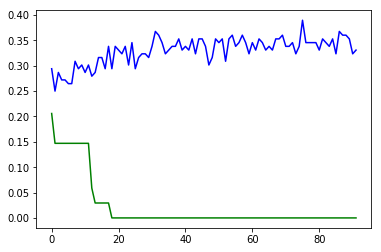

Starting epoch: 93 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


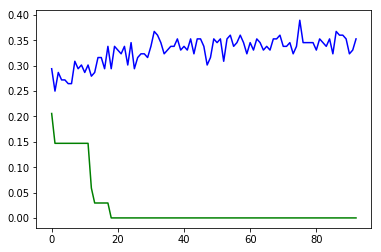

Starting epoch: 94 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


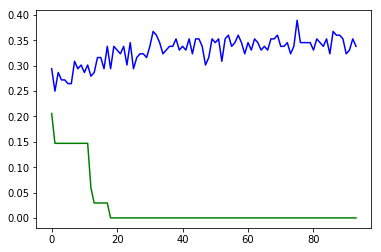

Starting epoch: 95 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


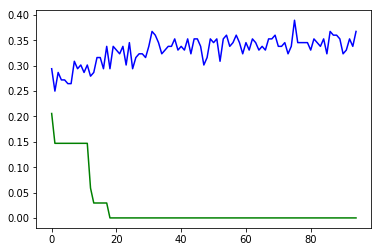

Starting epoch: 96 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


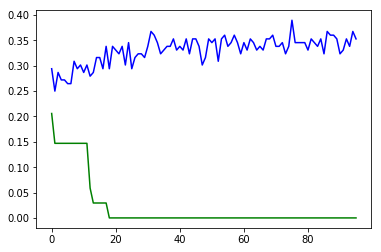

Starting epoch: 97 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


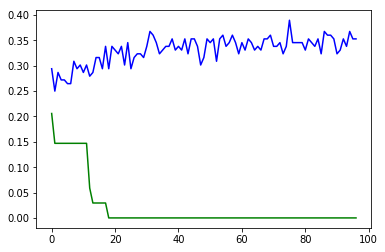

Starting epoch: 98 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


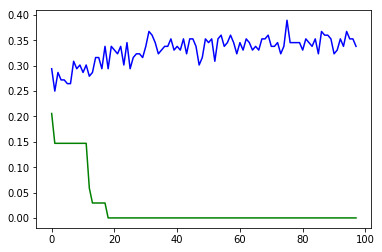

Starting epoch: 99 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


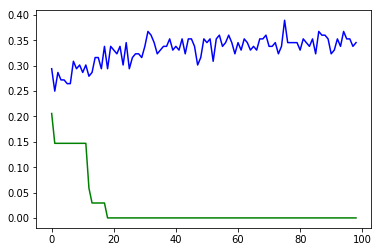

Starting epoch: 100 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


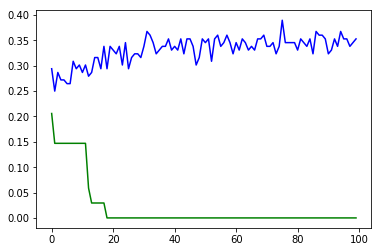

Starting epoch: 101 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


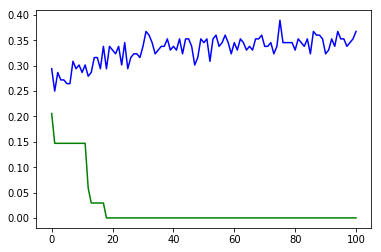

Starting epoch: 102 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


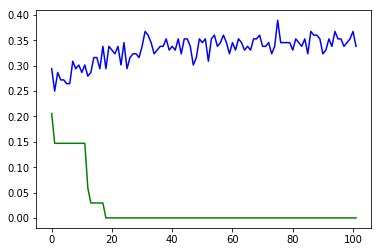

Starting epoch: 103 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


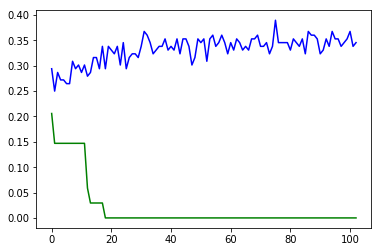

Starting epoch: 104 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


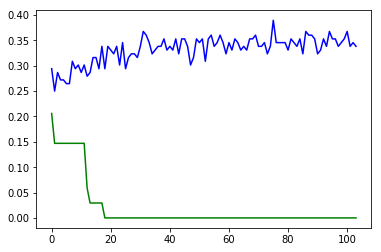

Starting epoch: 105 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


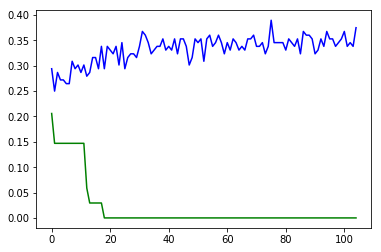

Starting epoch: 106 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


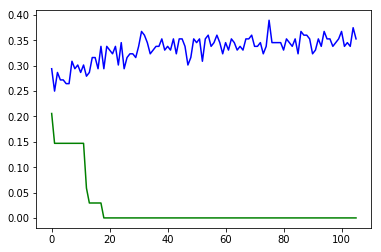

Starting epoch: 107 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


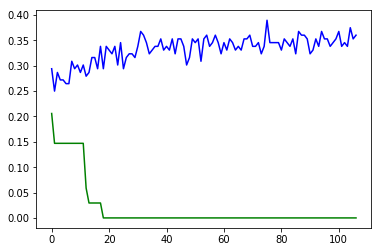

Starting epoch: 108 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


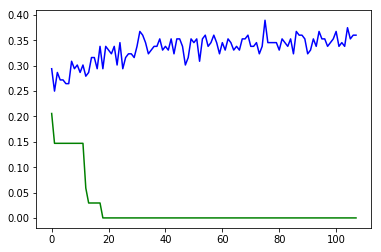

Starting epoch: 109 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


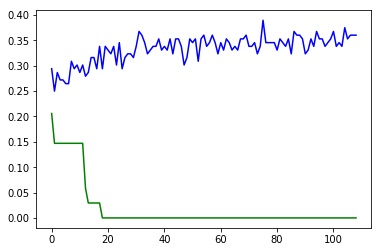

Starting epoch: 110 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


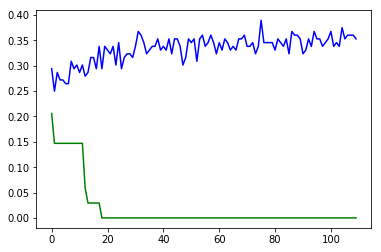

Starting epoch: 111 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


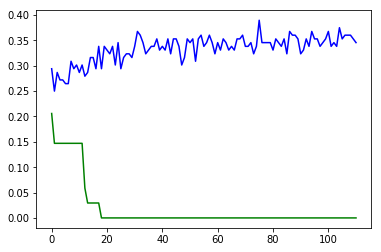

Starting epoch: 112 / 10000
training... done
Train Acc.: 0.330882
Val. Acc.: 0.000000


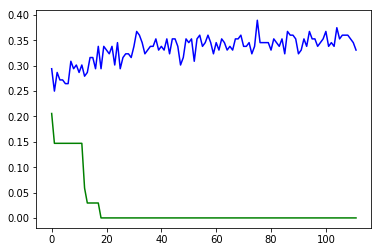

Starting epoch: 113 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


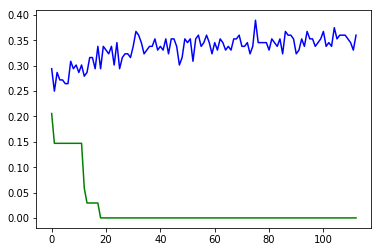

Starting epoch: 114 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


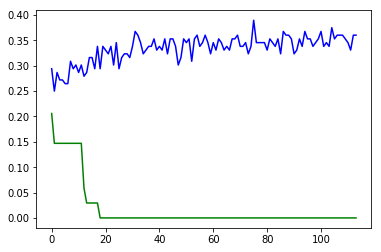

Starting epoch: 115 / 10000
training... done
Train Acc.: 0.389706
Val. Acc.: 0.000000


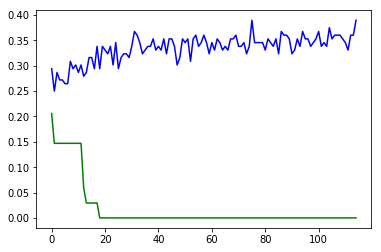

Starting epoch: 116 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


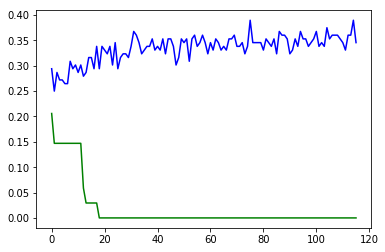

Starting epoch: 117 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


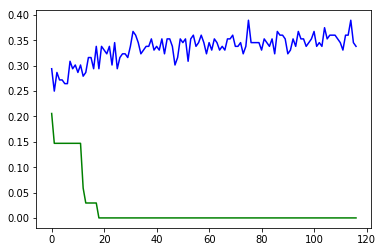

Starting epoch: 118 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


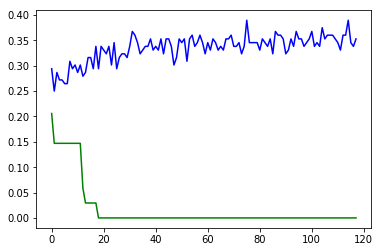

Starting epoch: 119 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


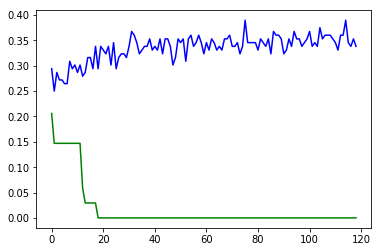

Starting epoch: 120 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


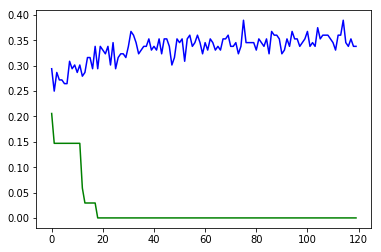

Starting epoch: 121 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


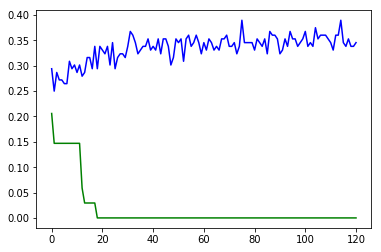

Starting epoch: 122 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


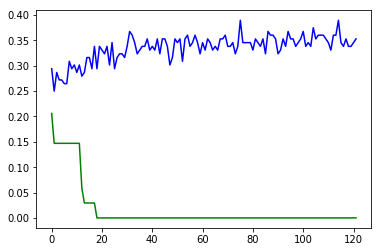

Starting epoch: 123 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


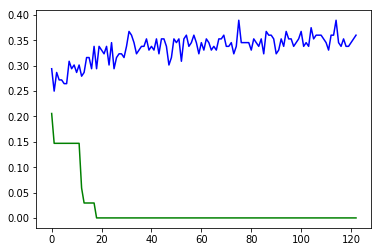

Starting epoch: 124 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


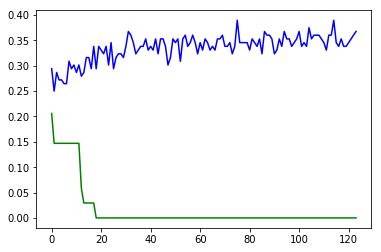

Starting epoch: 125 / 10000
training... done
Train Acc.: 0.338235
Val. Acc.: 0.000000


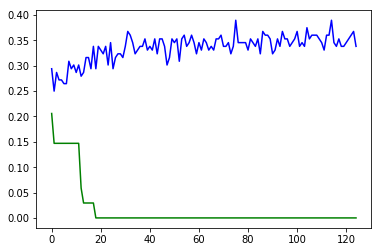

Starting epoch: 126 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


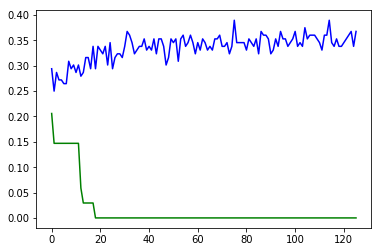

Starting epoch: 127 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


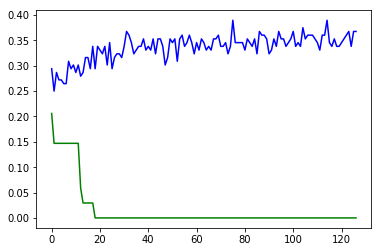

Starting epoch: 128 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


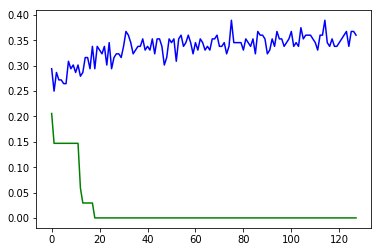

Starting epoch: 129 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


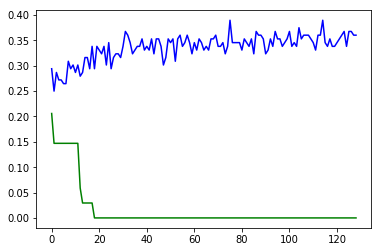

Starting epoch: 130 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


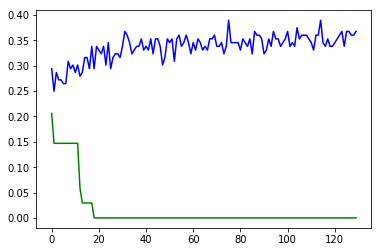

Starting epoch: 131 / 10000
training... done
Train Acc.: 0.330882
Val. Acc.: 0.000000


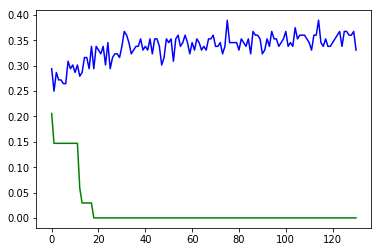

Starting epoch: 132 / 10000
training... done
Train Acc.: 0.330882
Val. Acc.: 0.000000


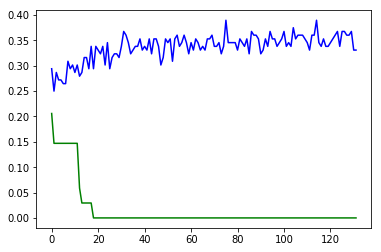

Starting epoch: 133 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


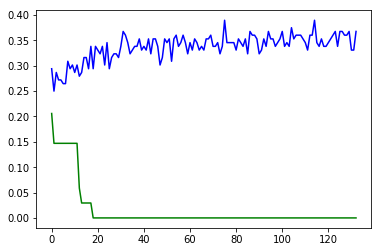

Starting epoch: 134 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


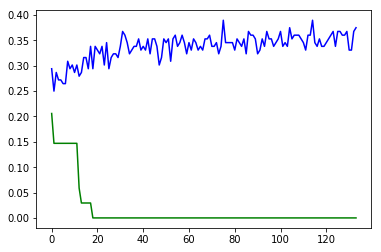

Starting epoch: 135 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


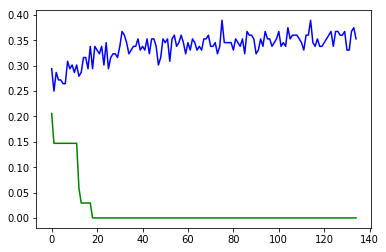

Starting epoch: 136 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


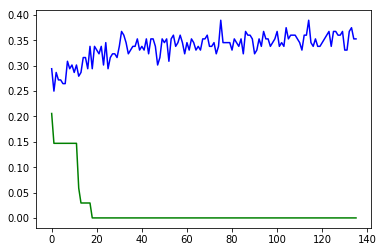

Starting epoch: 137 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


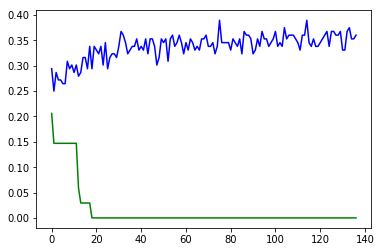

Starting epoch: 138 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


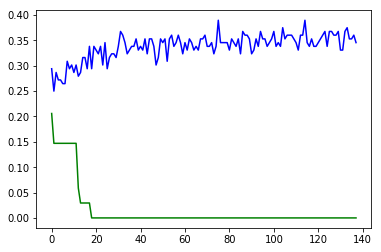

Starting epoch: 139 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


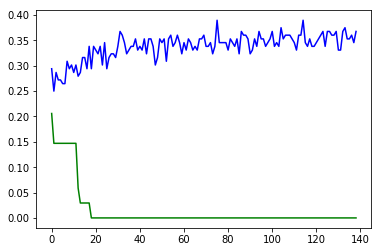

Starting epoch: 140 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


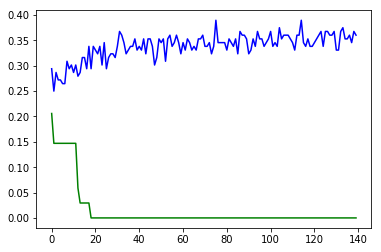

Starting epoch: 141 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


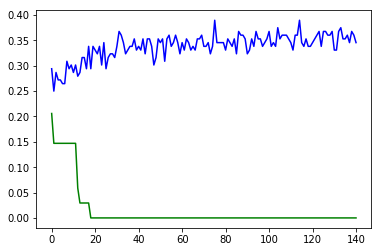

Starting epoch: 142 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


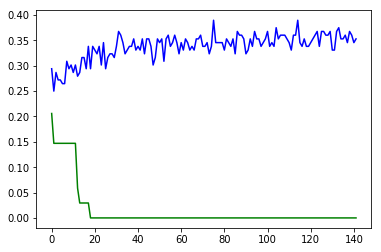

Starting epoch: 143 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


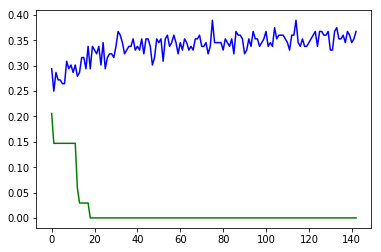

Starting epoch: 144 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


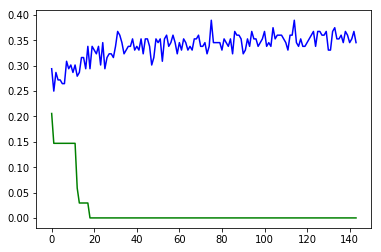

Starting epoch: 145 / 10000
training... done
Train Acc.: 0.316176
Val. Acc.: 0.000000


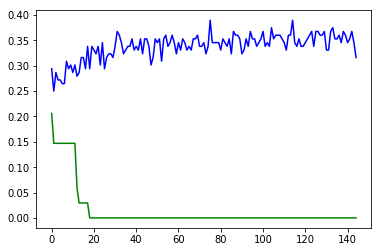

Starting epoch: 146 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


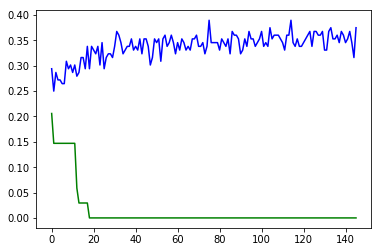

Starting epoch: 147 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


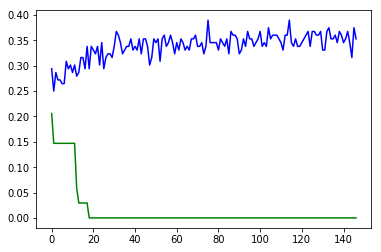

Starting epoch: 148 / 10000
training... done
Train Acc.: 0.389706
Val. Acc.: 0.000000


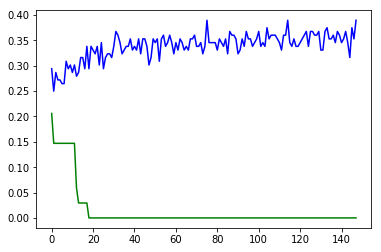

Starting epoch: 149 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


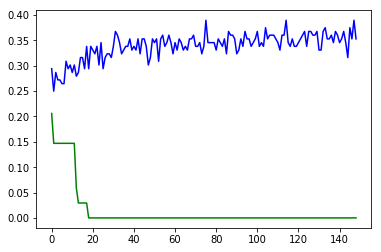

Starting epoch: 150 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


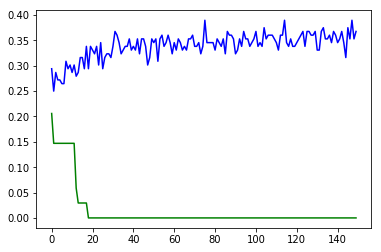

Starting epoch: 151 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


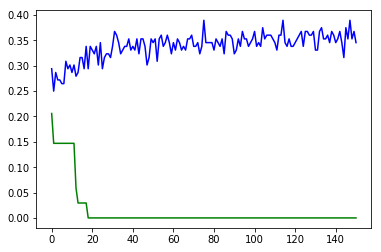

Starting epoch: 152 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


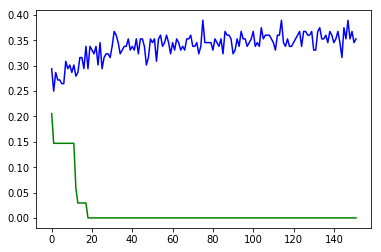

Starting epoch: 153 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


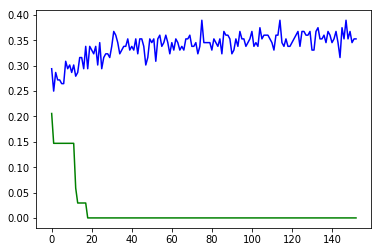

Starting epoch: 154 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


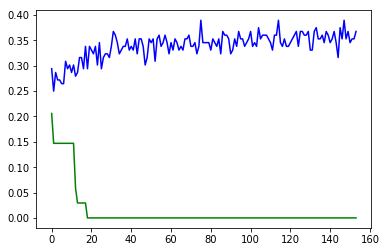

Starting epoch: 155 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


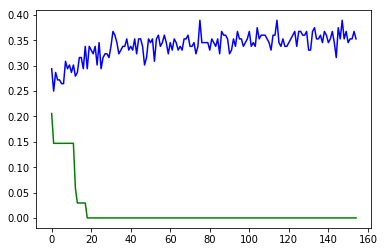

Starting epoch: 156 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


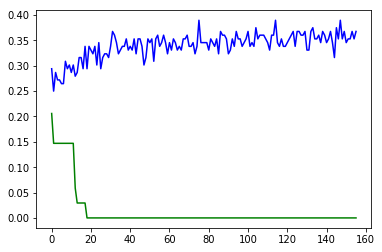

Starting epoch: 157 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


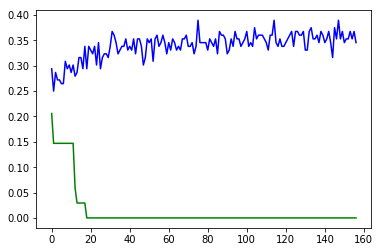

Starting epoch: 158 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


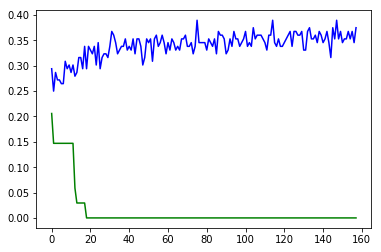

Starting epoch: 159 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


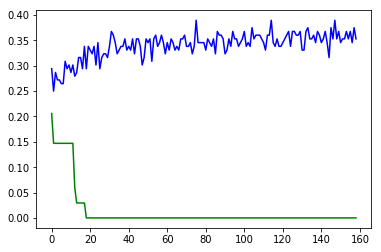

Starting epoch: 160 / 10000
training... done
Train Acc.: 0.323529
Val. Acc.: 0.000000


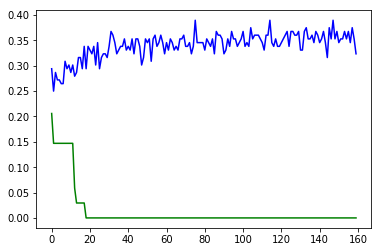

Starting epoch: 161 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


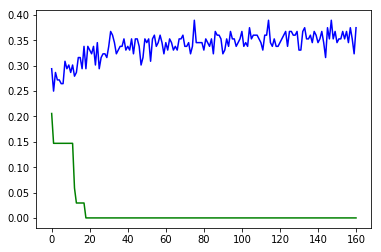

Starting epoch: 162 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


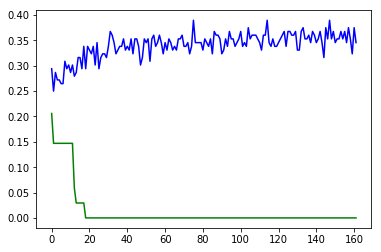

Starting epoch: 163 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


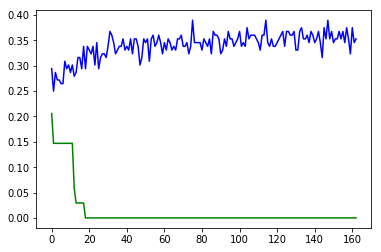

Starting epoch: 164 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


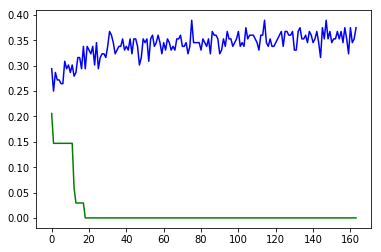

Starting epoch: 165 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


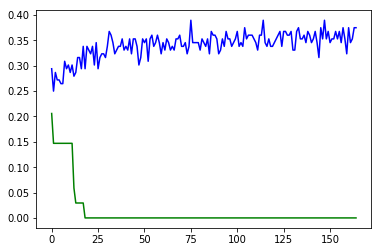

Starting epoch: 166 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


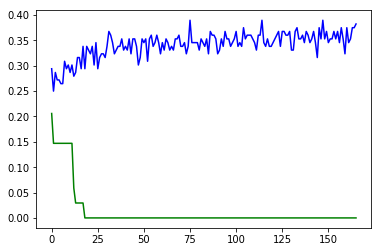

Starting epoch: 167 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


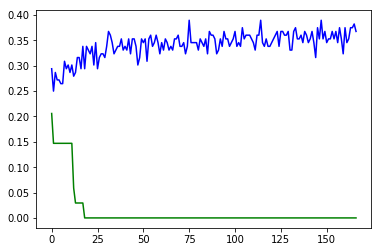

Starting epoch: 168 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


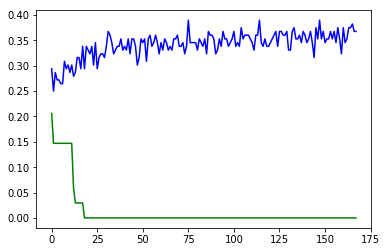

Starting epoch: 169 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


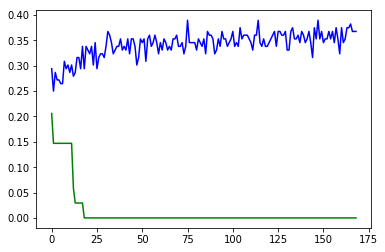

Starting epoch: 170 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


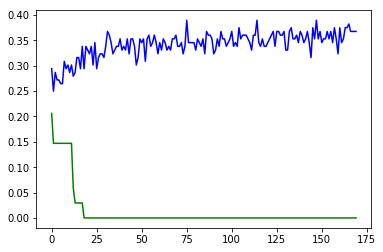

Starting epoch: 171 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


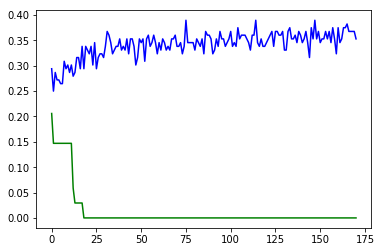

Starting epoch: 172 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


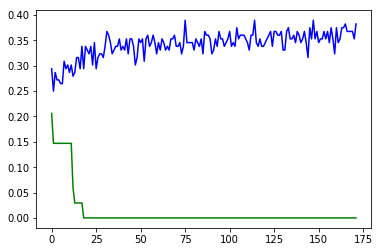

Starting epoch: 173 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


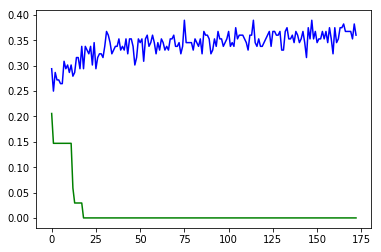

Starting epoch: 174 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


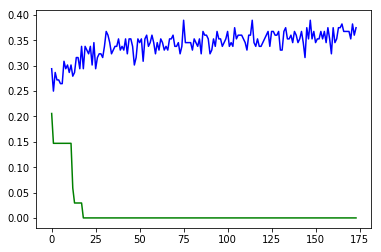

Starting epoch: 175 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


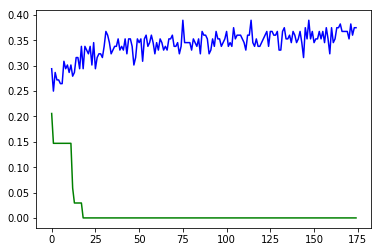

Starting epoch: 176 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


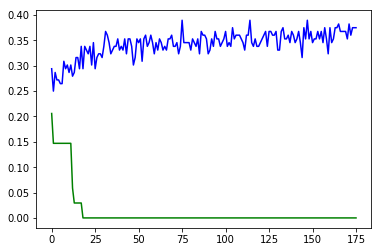

Starting epoch: 177 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


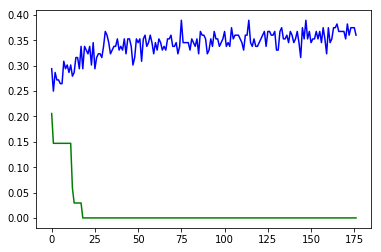

Starting epoch: 178 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


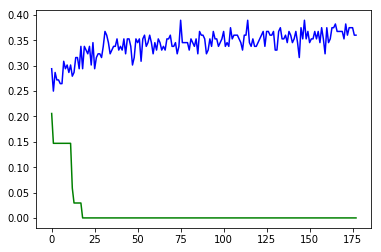

Starting epoch: 179 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


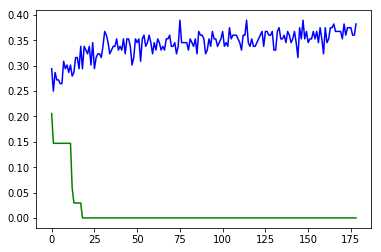

Starting epoch: 180 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


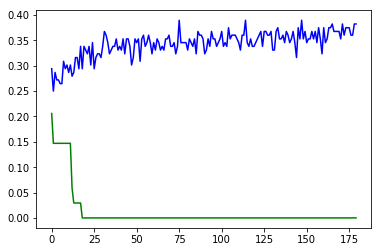

Starting epoch: 181 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


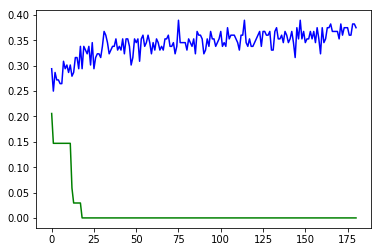

Starting epoch: 182 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


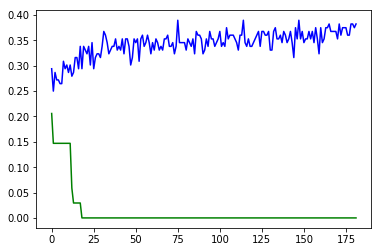

Starting epoch: 183 / 10000
training... done
Train Acc.: 0.352941
Val. Acc.: 0.000000


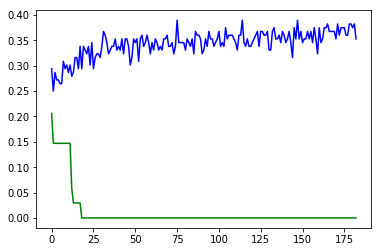

Starting epoch: 184 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


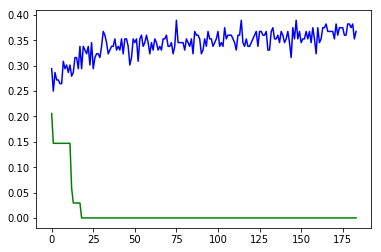

Starting epoch: 185 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


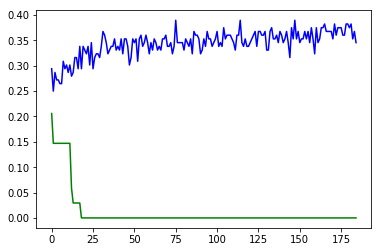

Starting epoch: 186 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


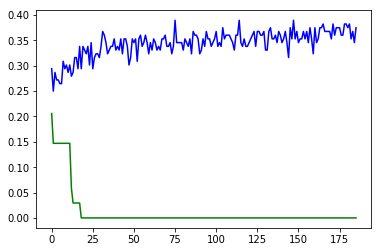

Starting epoch: 187 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


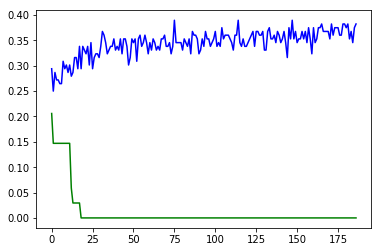

Starting epoch: 188 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


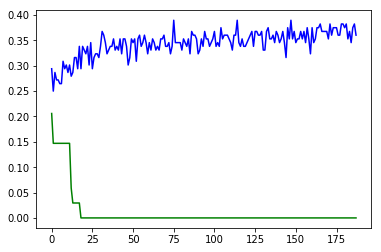

Starting epoch: 189 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


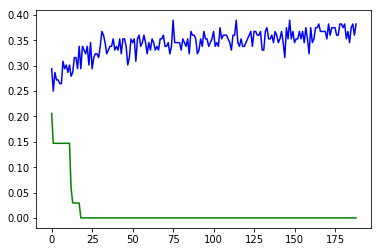

Starting epoch: 190 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


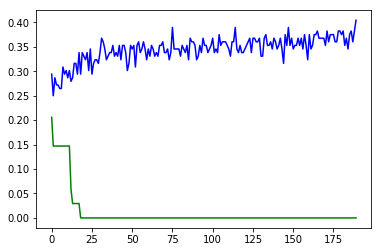

Starting epoch: 191 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


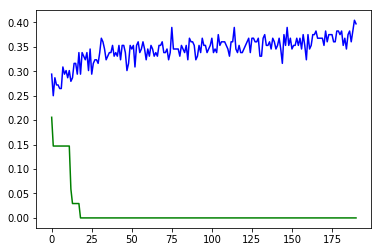

Starting epoch: 192 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


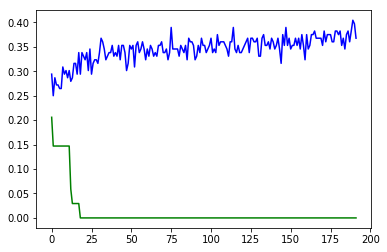

Starting epoch: 193 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


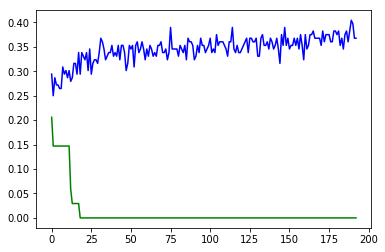

Starting epoch: 194 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


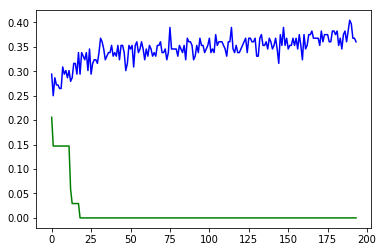

Starting epoch: 195 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


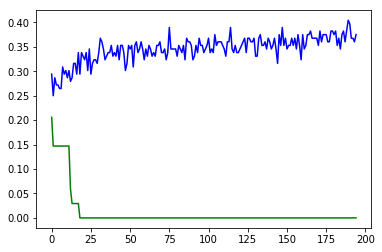

Starting epoch: 196 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


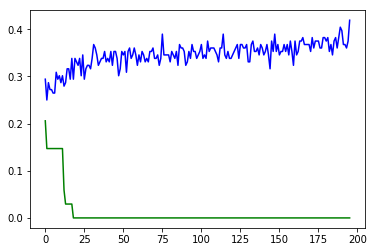

Starting epoch: 197 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


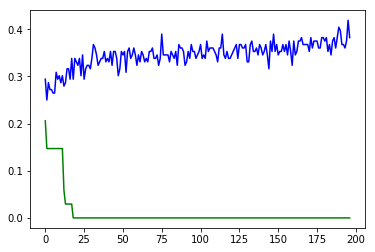

Starting epoch: 198 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


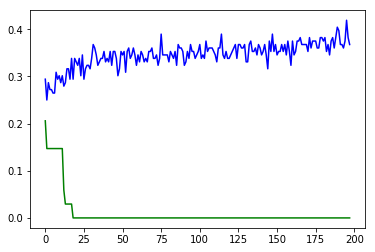

Starting epoch: 199 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


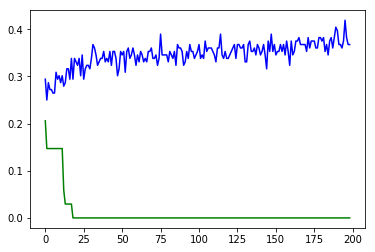

Starting epoch: 200 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


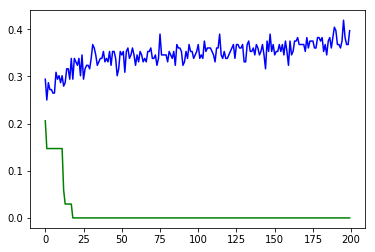

Starting epoch: 201 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


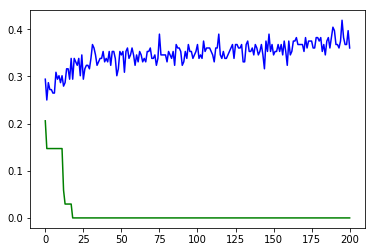

Starting epoch: 202 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


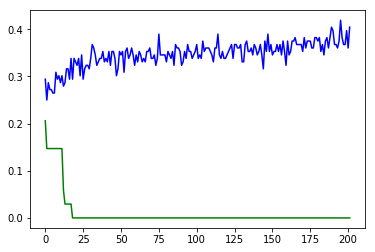

Starting epoch: 203 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


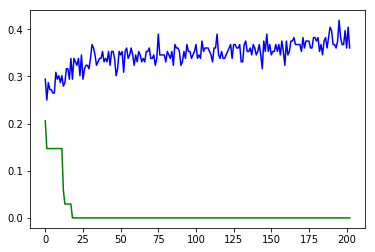

Starting epoch: 204 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


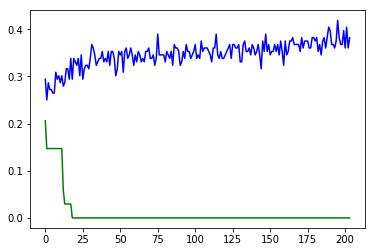

Starting epoch: 205 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


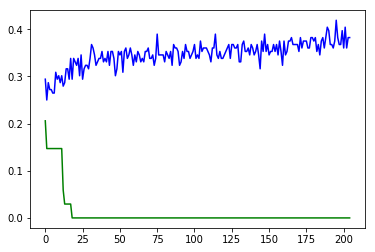

Starting epoch: 206 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


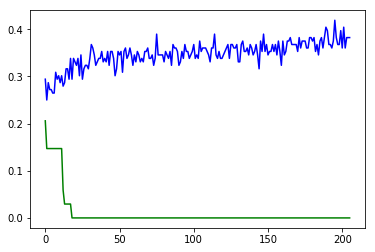

Starting epoch: 207 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


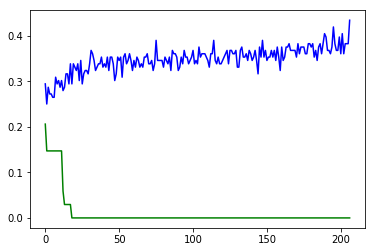

Starting epoch: 208 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


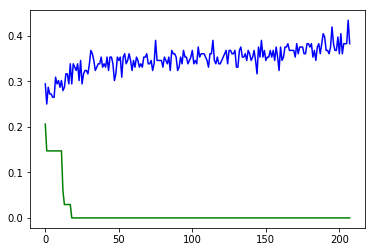

Starting epoch: 209 / 10000
training... done
Train Acc.: 0.389706
Val. Acc.: 0.000000


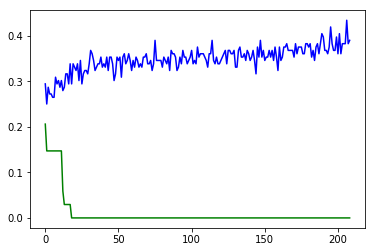

Starting epoch: 210 / 10000
training... done
Train Acc.: 0.345588
Val. Acc.: 0.000000


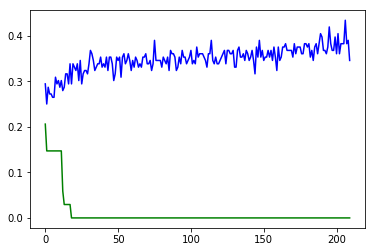

Starting epoch: 211 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


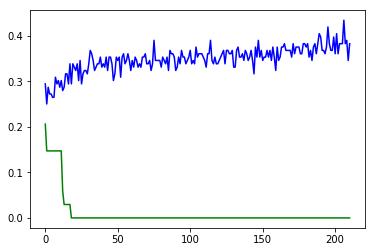

Starting epoch: 212 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


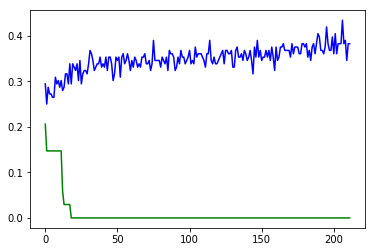

Starting epoch: 213 / 10000
training... done
Train Acc.: 0.389706
Val. Acc.: 0.000000


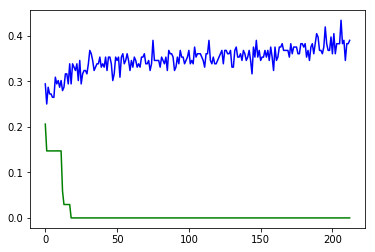

Starting epoch: 214 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


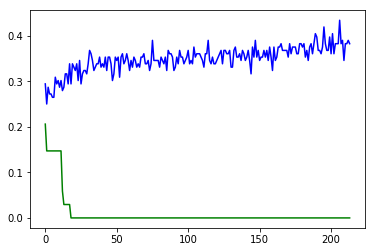

Starting epoch: 215 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


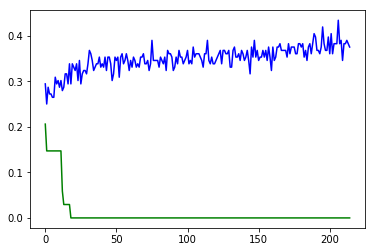

Starting epoch: 216 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


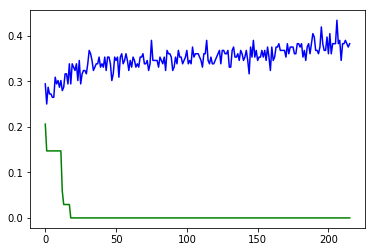

Starting epoch: 217 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


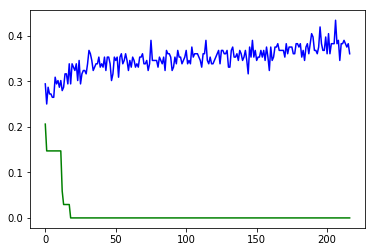

Starting epoch: 218 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


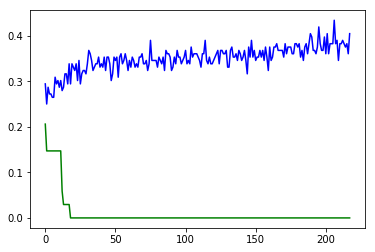

Starting epoch: 219 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


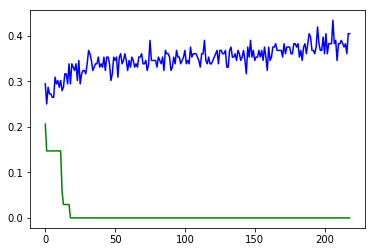

Starting epoch: 220 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


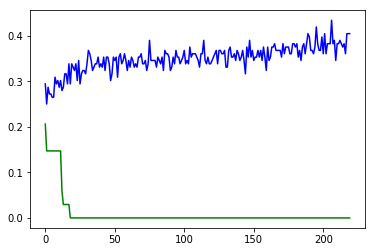

Starting epoch: 221 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


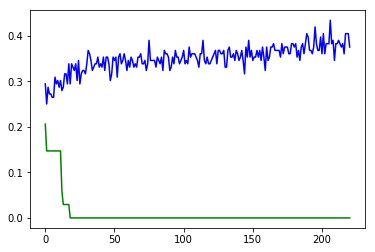

Starting epoch: 222 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


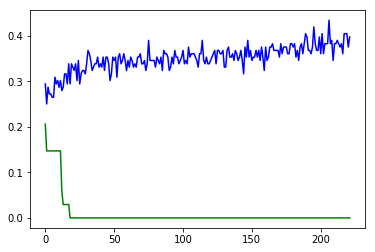

Starting epoch: 223 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


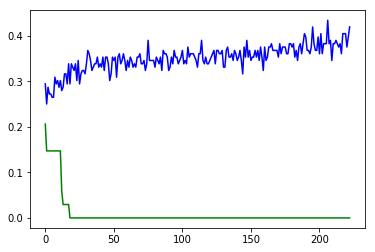

Starting epoch: 224 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


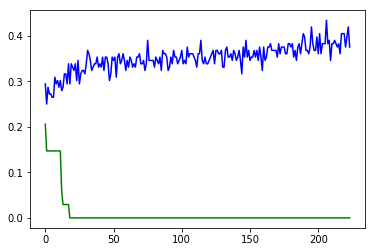

Starting epoch: 225 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


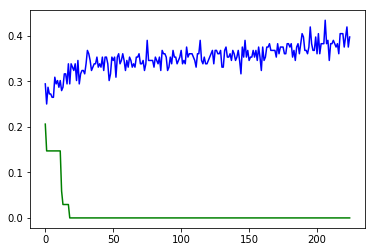

Starting epoch: 226 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


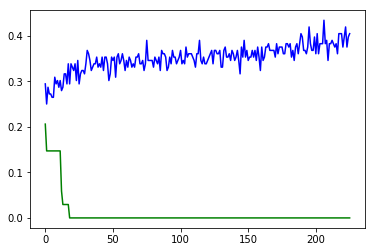

Starting epoch: 227 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


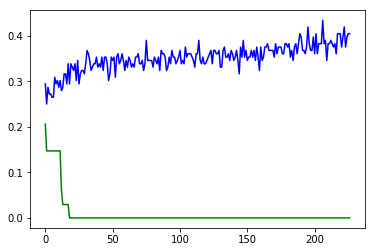

Starting epoch: 228 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


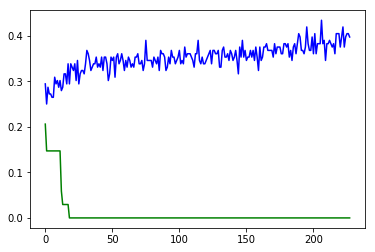

Starting epoch: 229 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


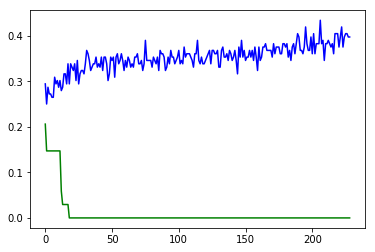

Starting epoch: 230 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


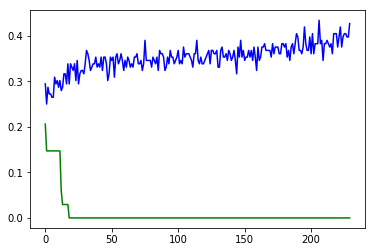

Starting epoch: 231 / 10000
training... done
Train Acc.: 0.360294
Val. Acc.: 0.000000


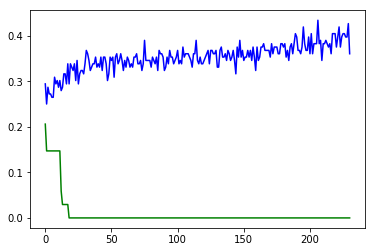

Starting epoch: 232 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


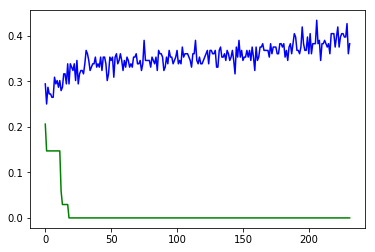

Starting epoch: 233 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


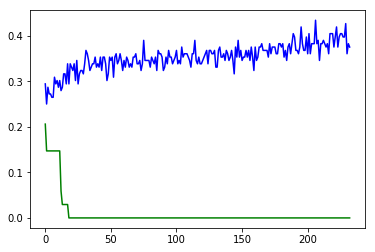

Starting epoch: 234 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


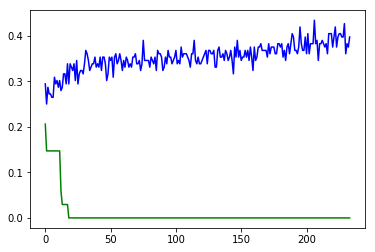

Starting epoch: 235 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


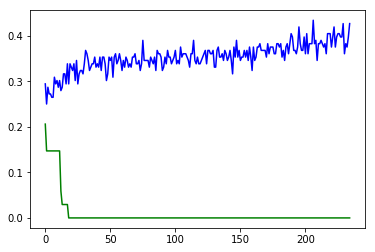

Starting epoch: 236 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


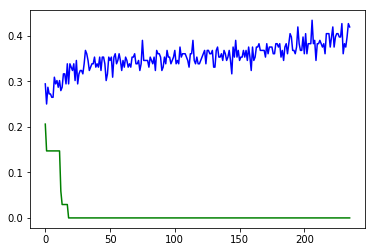

Starting epoch: 237 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


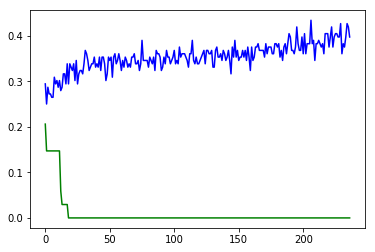

Starting epoch: 238 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


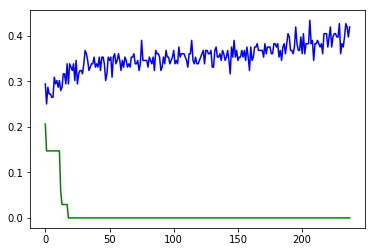

Starting epoch: 239 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


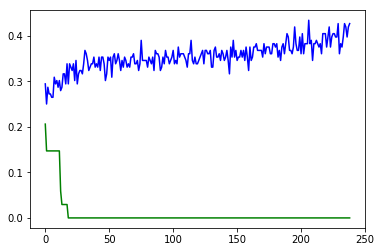

Starting epoch: 240 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


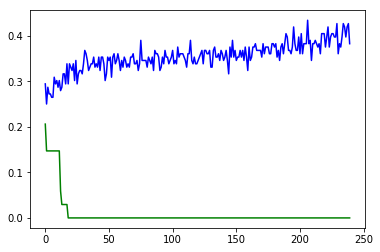

Starting epoch: 241 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


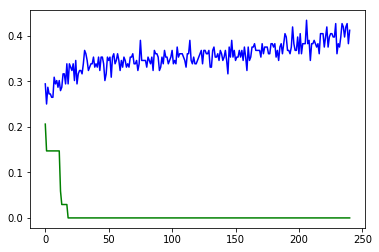

Starting epoch: 242 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


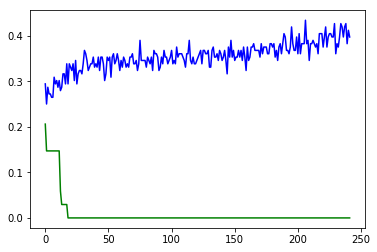

Starting epoch: 243 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


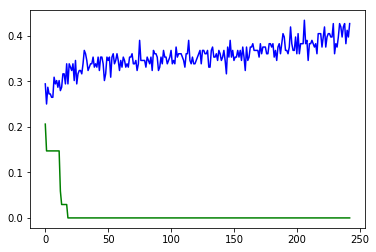

Starting epoch: 244 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


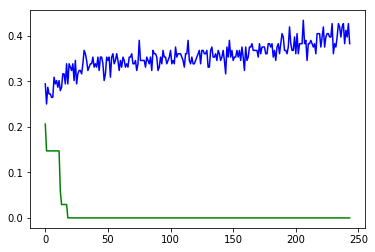

Starting epoch: 245 / 10000
training... done
Train Acc.: 0.389706
Val. Acc.: 0.000000


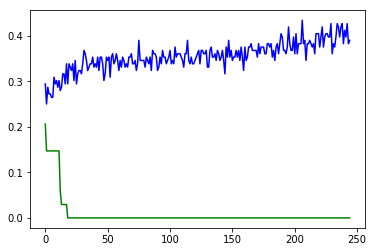

Starting epoch: 246 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


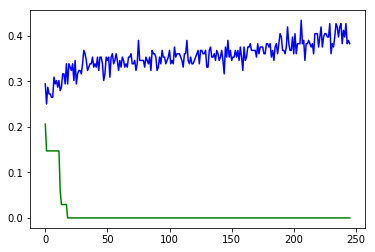

Starting epoch: 247 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


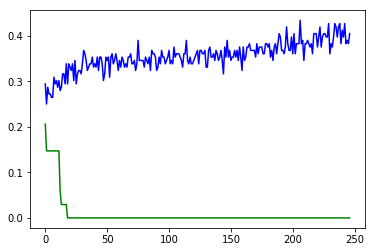

Starting epoch: 248 / 10000
training... done
Train Acc.: 0.389706
Val. Acc.: 0.000000


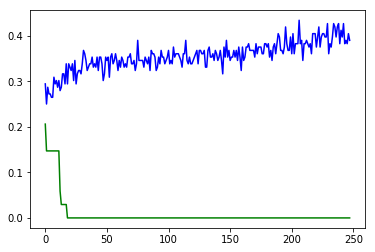

Starting epoch: 249 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


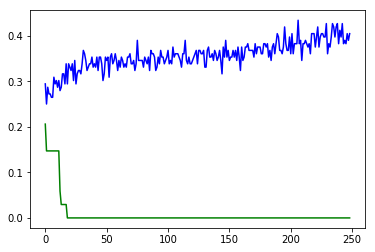

Starting epoch: 250 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


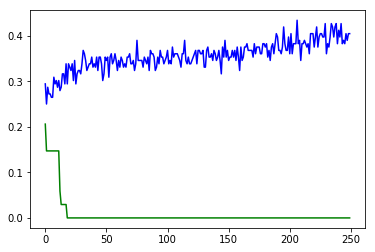

Starting epoch: 251 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


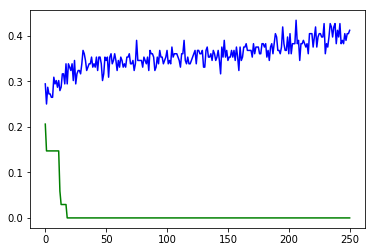

Starting epoch: 252 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


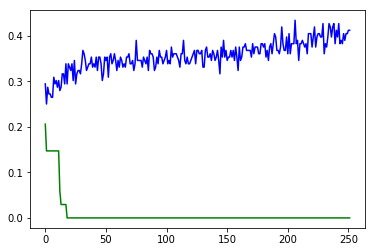

Starting epoch: 253 / 10000
training... done
Train Acc.: 0.389706
Val. Acc.: 0.000000


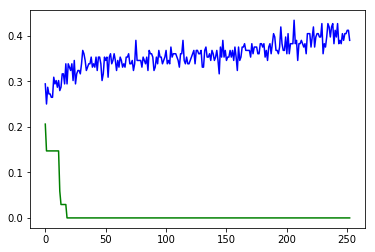

Starting epoch: 254 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


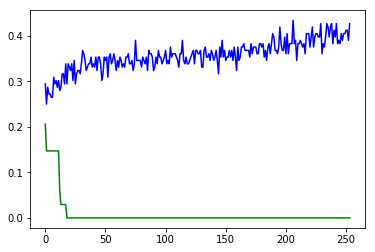

Starting epoch: 255 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


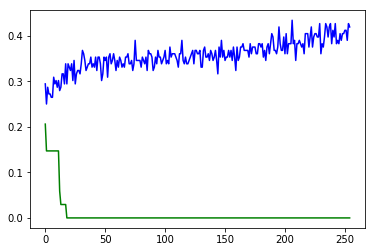

Starting epoch: 256 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


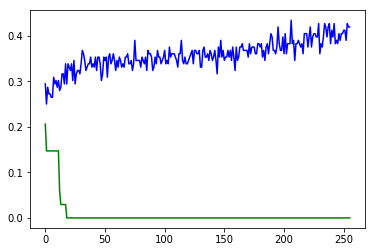

Starting epoch: 257 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


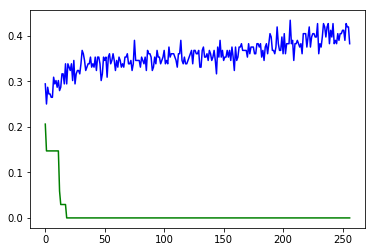

Starting epoch: 258 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


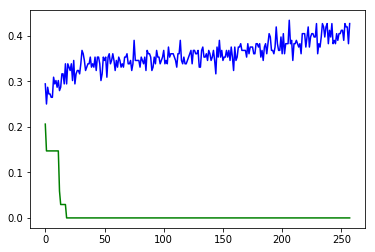

Starting epoch: 259 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


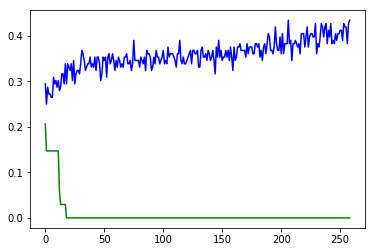

Starting epoch: 260 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


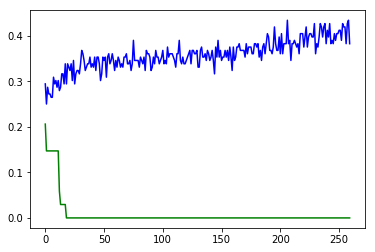

Starting epoch: 261 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


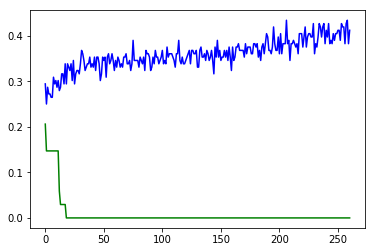

Starting epoch: 262 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


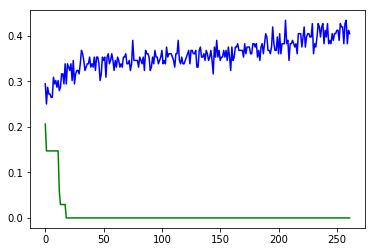

Starting epoch: 263 / 10000
training... done
Train Acc.: 0.389706
Val. Acc.: 0.000000


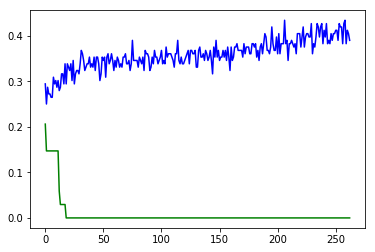

Starting epoch: 264 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


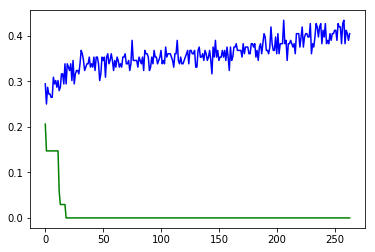

Starting epoch: 265 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


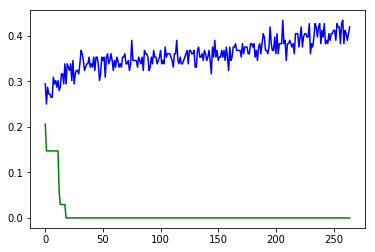

Starting epoch: 266 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


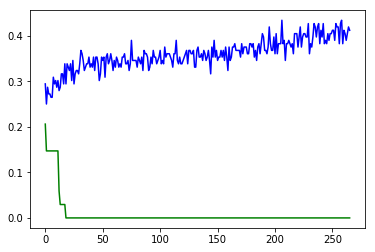

Starting epoch: 267 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


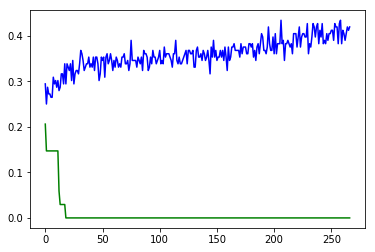

Starting epoch: 268 / 10000
training... done
Train Acc.: 0.455882
Val. Acc.: 0.000000


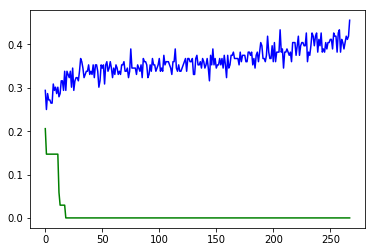

Starting epoch: 269 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


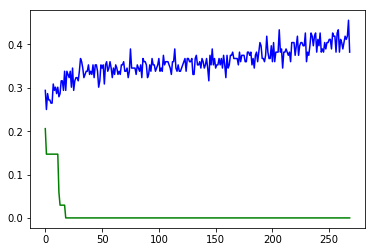

Starting epoch: 270 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


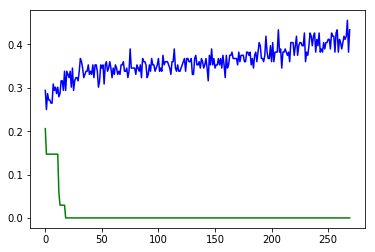

Starting epoch: 271 / 10000
training... done
Train Acc.: 0.389706
Val. Acc.: 0.000000


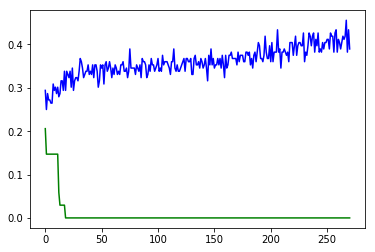

Starting epoch: 272 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


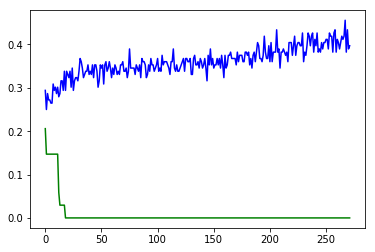

Starting epoch: 273 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


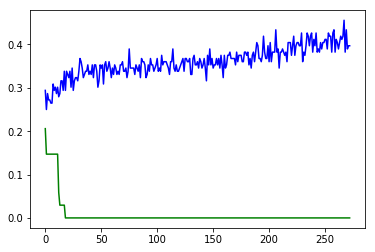

Starting epoch: 274 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


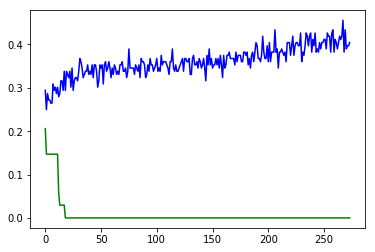

Starting epoch: 275 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


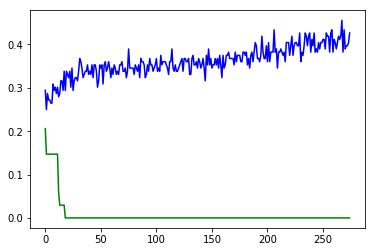

Starting epoch: 276 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


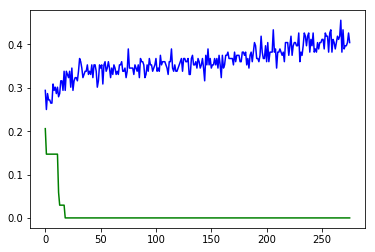

Starting epoch: 277 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


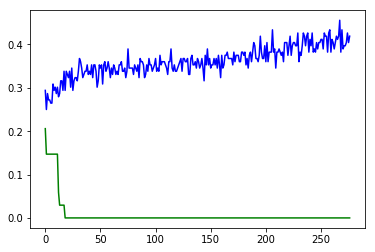

Starting epoch: 278 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


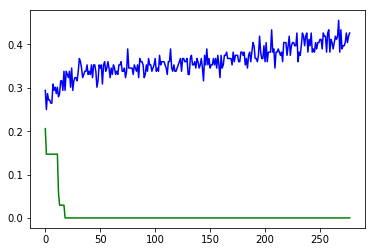

Starting epoch: 279 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


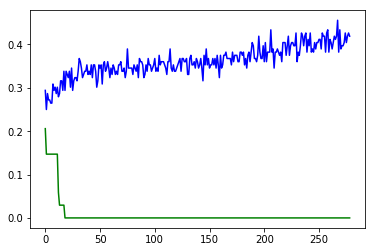

Starting epoch: 280 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


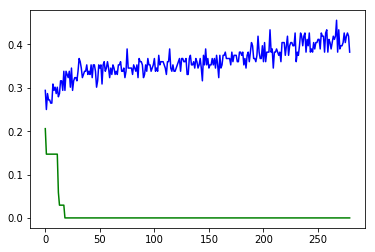

Starting epoch: 281 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


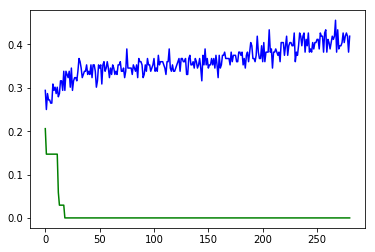

Starting epoch: 282 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


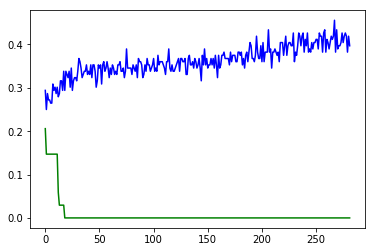

Starting epoch: 283 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


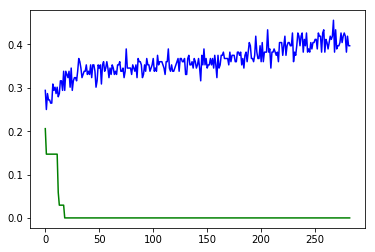

Starting epoch: 284 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


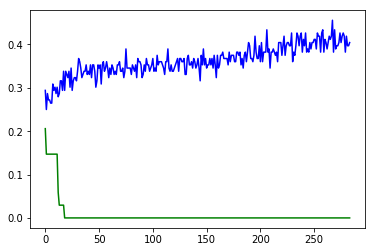

Starting epoch: 285 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


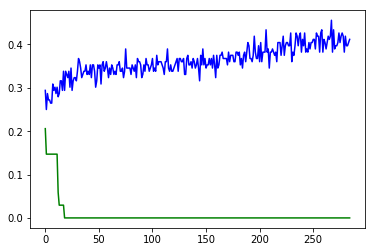

Starting epoch: 286 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


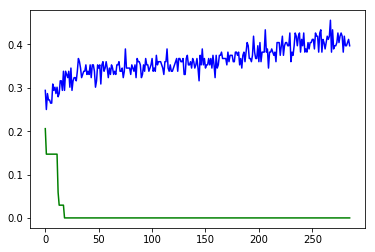

Starting epoch: 287 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


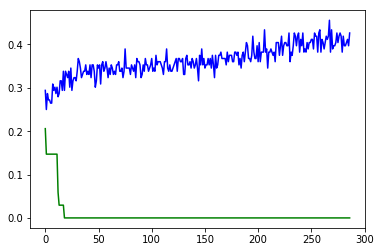

Starting epoch: 288 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


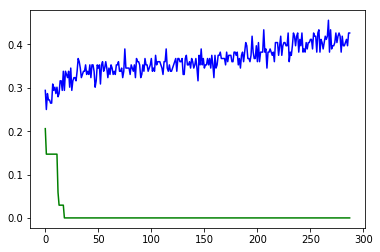

Starting epoch: 289 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


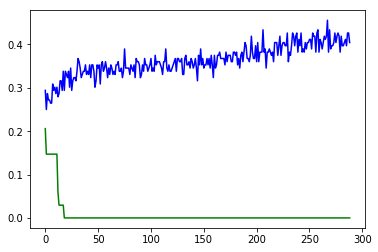

Starting epoch: 290 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


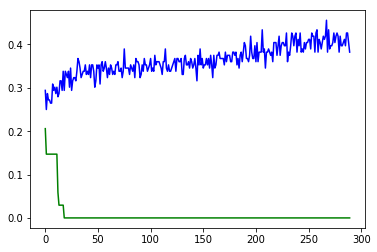

Starting epoch: 291 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


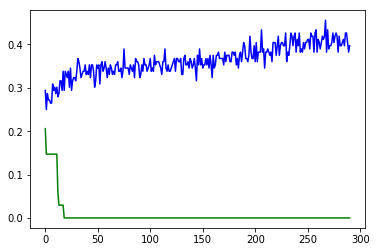

Starting epoch: 292 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


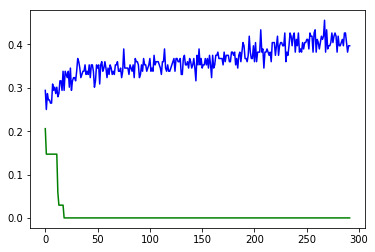

Starting epoch: 293 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


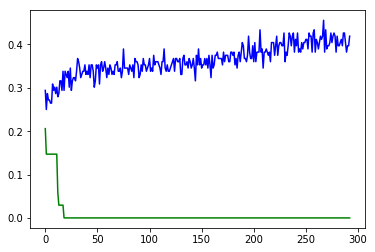

Starting epoch: 294 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


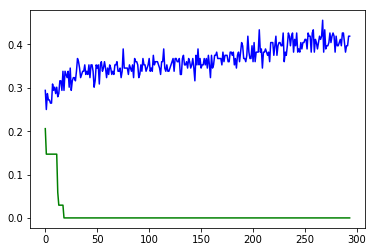

Starting epoch: 295 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


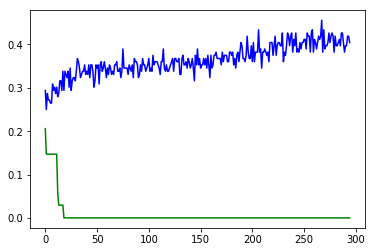

Starting epoch: 296 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


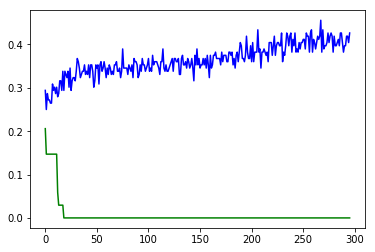

Starting epoch: 297 / 10000
training... done
Train Acc.: 0.448529
Val. Acc.: 0.000000


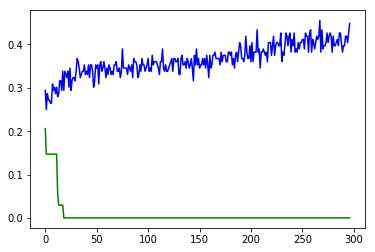

Starting epoch: 298 / 10000
training... done
Train Acc.: 0.448529
Val. Acc.: 0.000000


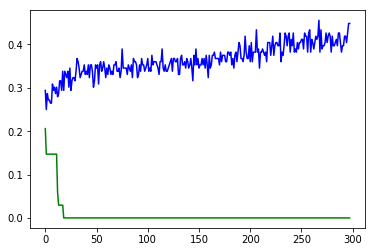

Starting epoch: 299 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


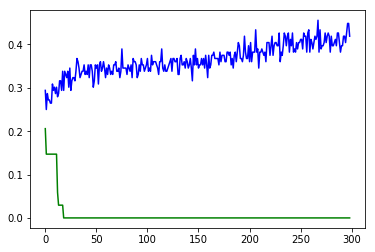

Starting epoch: 300 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


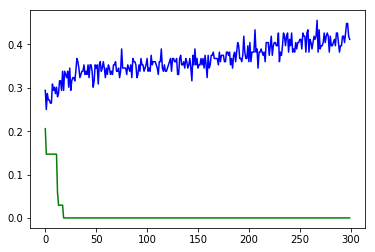

Starting epoch: 301 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


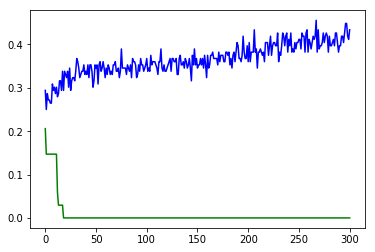

Starting epoch: 302 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


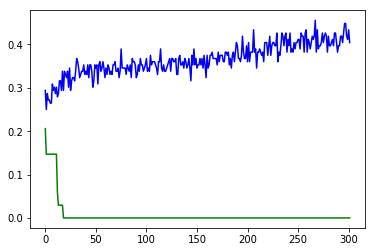

Starting epoch: 303 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


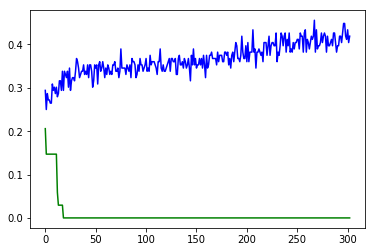

Starting epoch: 304 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


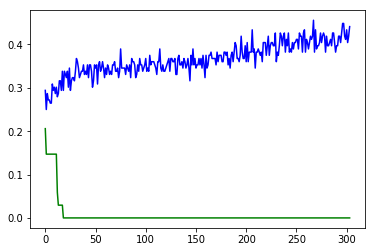

Starting epoch: 305 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


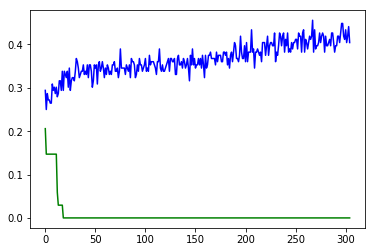

Starting epoch: 306 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


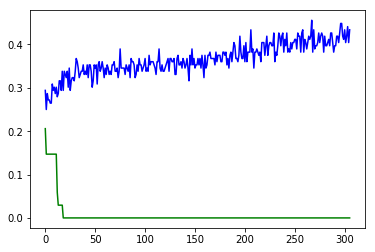

Starting epoch: 307 / 10000
training... done
Train Acc.: 0.367647
Val. Acc.: 0.000000


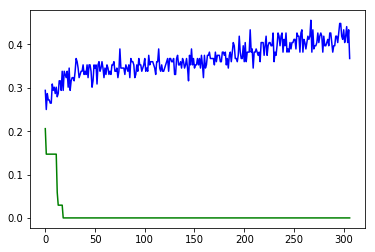

Starting epoch: 308 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


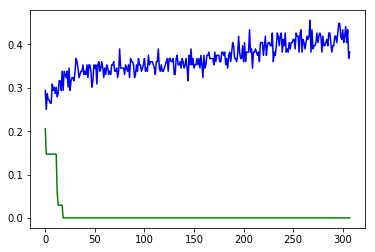

Starting epoch: 309 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


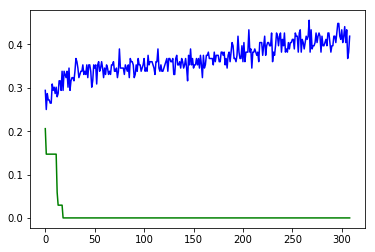

Starting epoch: 310 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


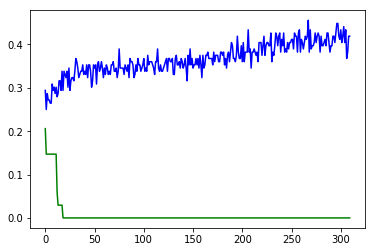

Starting epoch: 311 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


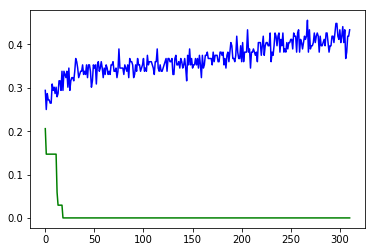

Starting epoch: 312 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


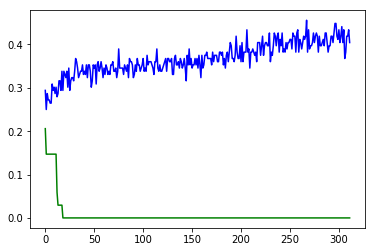

Starting epoch: 313 / 10000
training... done
Train Acc.: 0.455882
Val. Acc.: 0.000000


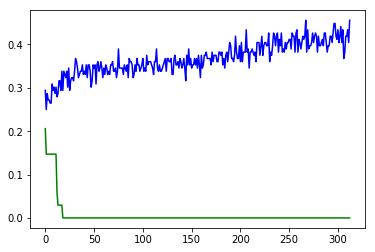

Starting epoch: 314 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


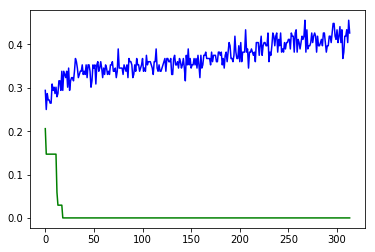

Starting epoch: 315 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


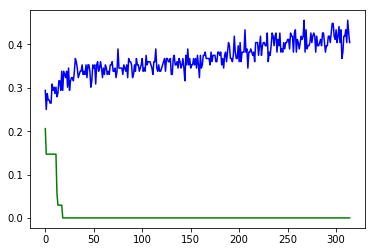

Starting epoch: 316 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


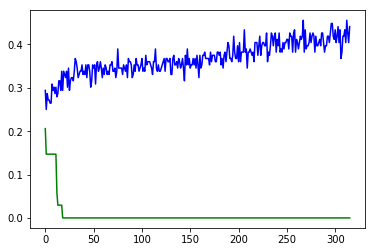

Starting epoch: 317 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


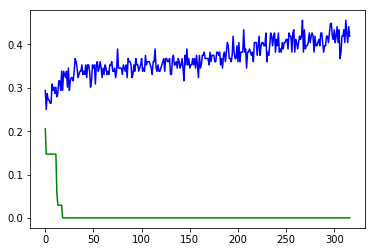

Starting epoch: 318 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


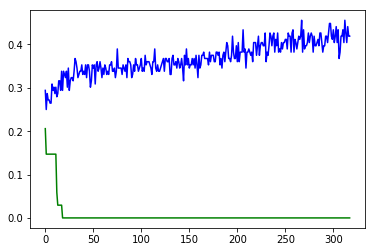

Starting epoch: 319 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


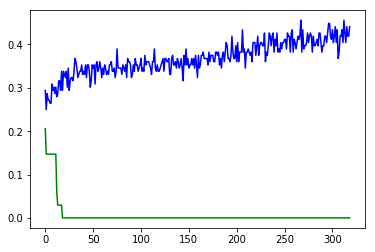

Starting epoch: 320 / 10000
training... done
Train Acc.: 0.455882
Val. Acc.: 0.000000


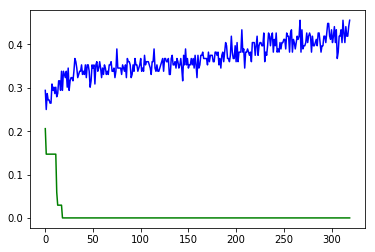

Starting epoch: 321 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


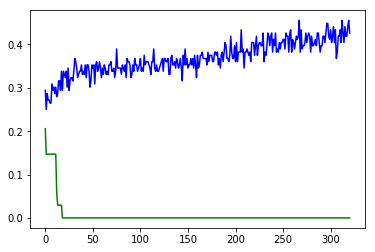

Starting epoch: 322 / 10000
training... done
Train Acc.: 0.455882
Val. Acc.: 0.000000


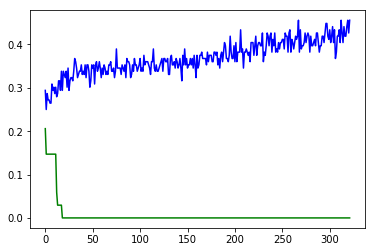

Starting epoch: 323 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


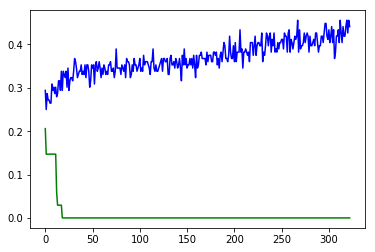

Starting epoch: 324 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


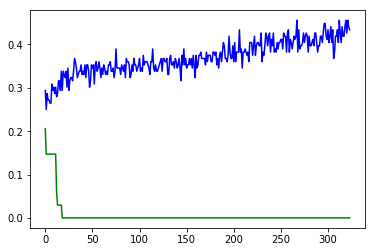

Starting epoch: 325 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


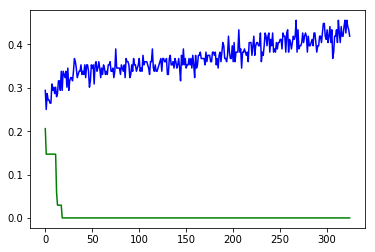

Starting epoch: 326 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


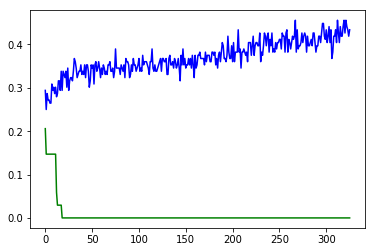

Starting epoch: 327 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


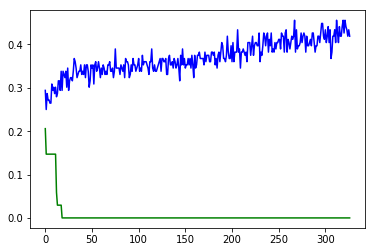

Starting epoch: 328 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


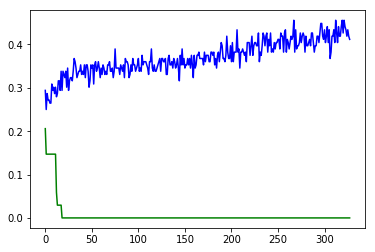

Starting epoch: 329 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


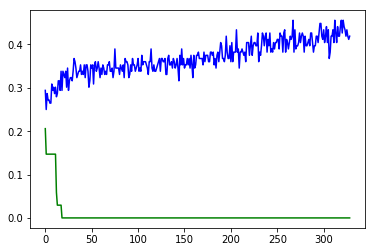

Starting epoch: 330 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


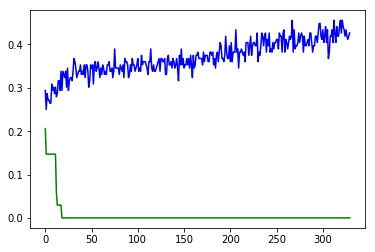

Starting epoch: 331 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


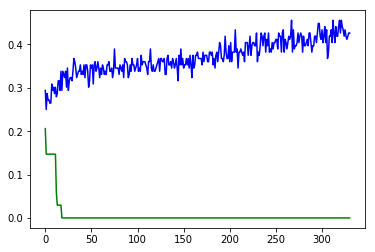

Starting epoch: 332 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


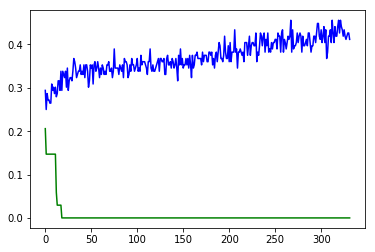

Starting epoch: 333 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


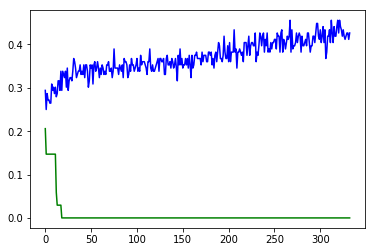

Starting epoch: 334 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


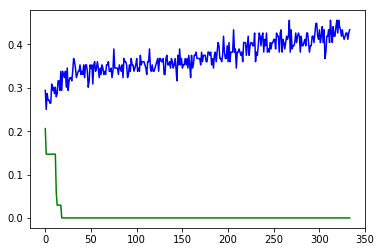

Starting epoch: 335 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


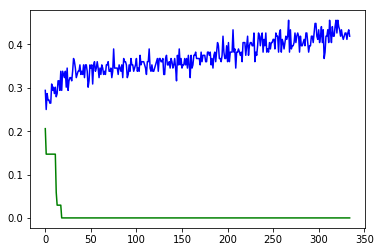

Starting epoch: 336 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


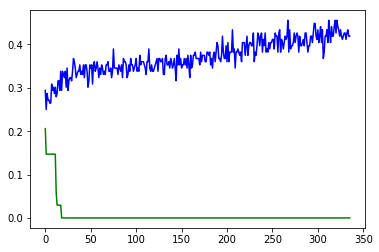

Starting epoch: 337 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


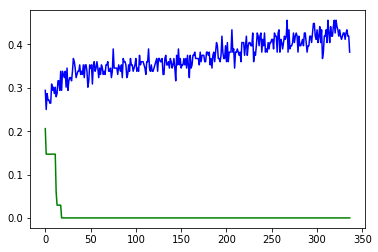

Starting epoch: 338 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


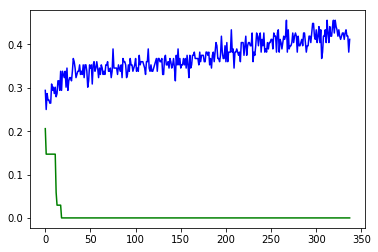

Starting epoch: 339 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


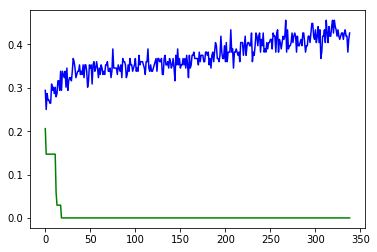

Starting epoch: 340 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


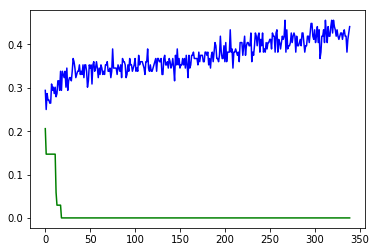

Starting epoch: 341 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


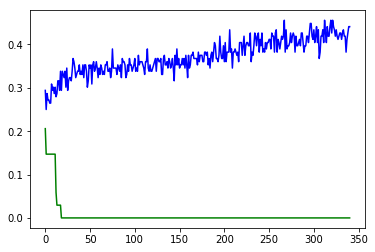

Starting epoch: 342 / 10000
training... done
Train Acc.: 0.448529
Val. Acc.: 0.000000


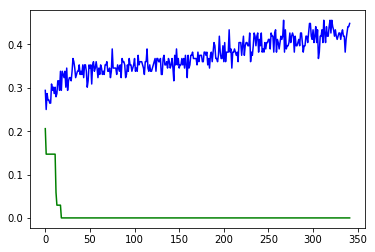

Starting epoch: 343 / 10000
training... done
Train Acc.: 0.448529
Val. Acc.: 0.000000


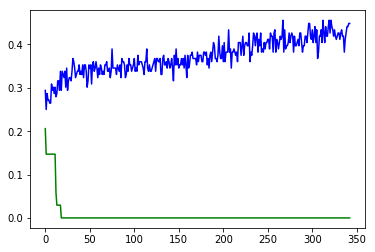

Starting epoch: 344 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


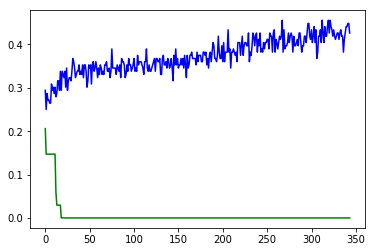

Starting epoch: 345 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


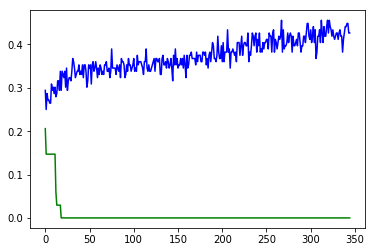

Starting epoch: 346 / 10000
training... done
Train Acc.: 0.382353
Val. Acc.: 0.000000


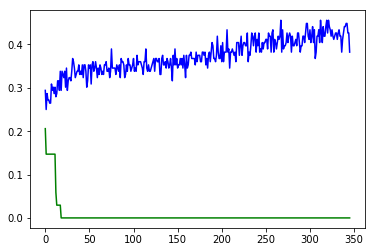

Starting epoch: 347 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


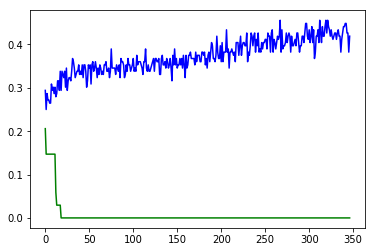

Starting epoch: 348 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


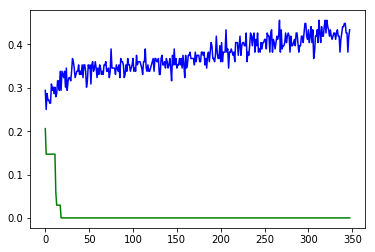

Starting epoch: 349 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


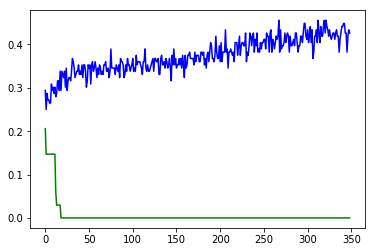

Starting epoch: 350 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


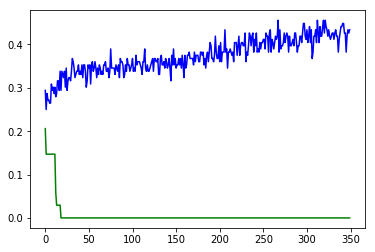

Starting epoch: 351 / 10000
training... done
Train Acc.: 0.448529
Val. Acc.: 0.000000


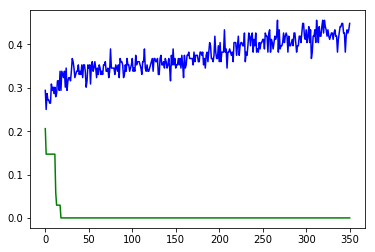

Starting epoch: 352 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


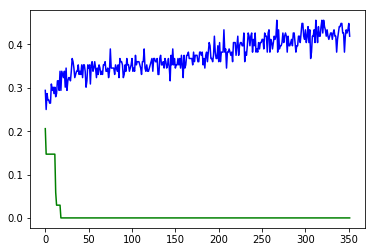

Starting epoch: 353 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


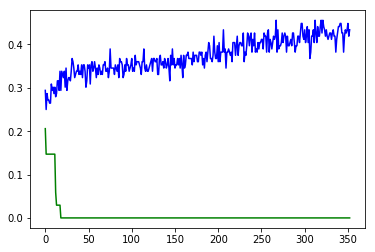

Starting epoch: 354 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


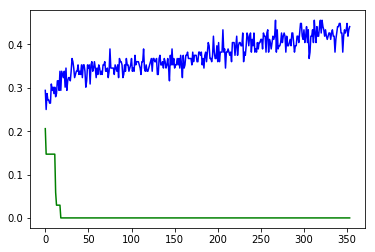

Starting epoch: 355 / 10000
training... done
Train Acc.: 0.455882
Val. Acc.: 0.000000


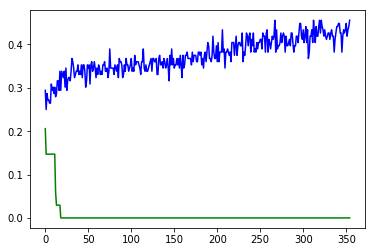

Starting epoch: 356 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


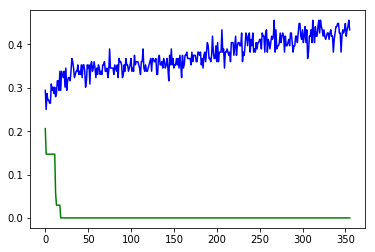

Starting epoch: 357 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


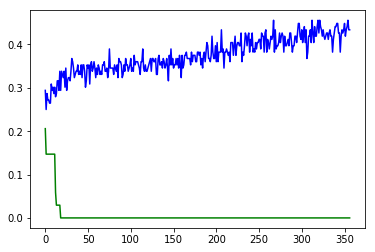

Starting epoch: 358 / 10000
training... done
Train Acc.: 0.448529
Val. Acc.: 0.000000


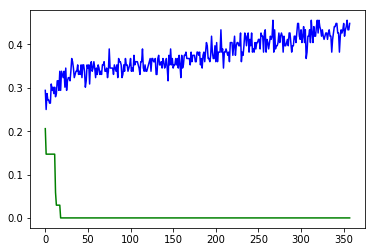

Starting epoch: 359 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


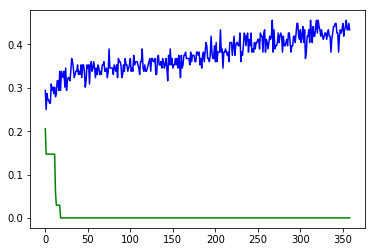

Starting epoch: 360 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


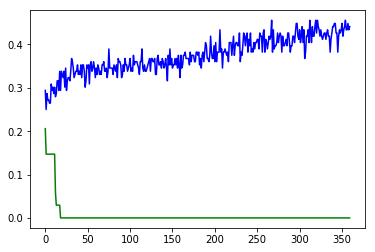

Starting epoch: 361 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


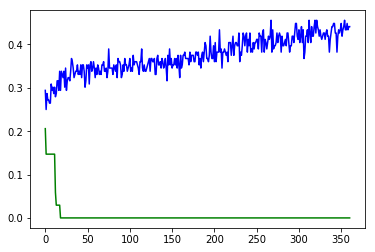

Starting epoch: 362 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


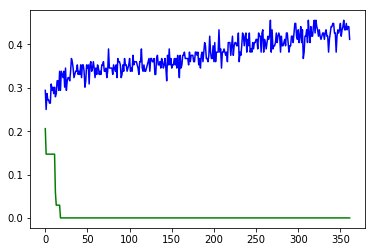

Starting epoch: 363 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


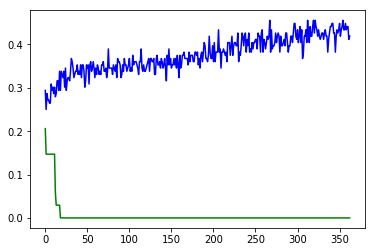

Starting epoch: 364 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


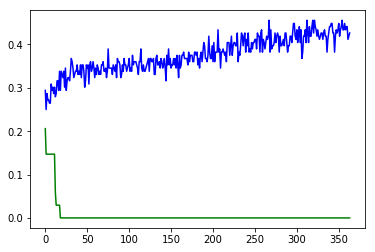

Starting epoch: 365 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


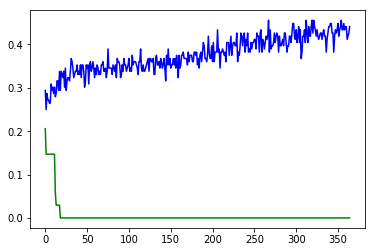

Starting epoch: 366 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


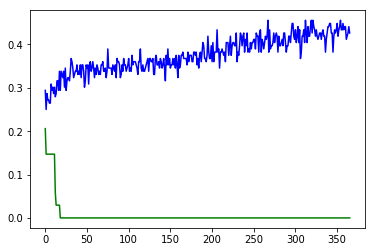

Starting epoch: 367 / 10000
training... done
Train Acc.: 0.448529
Val. Acc.: 0.000000


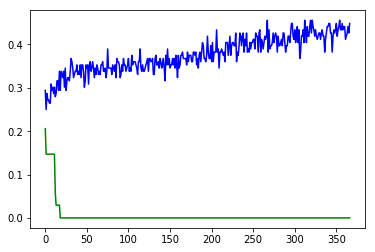

Starting epoch: 368 / 10000
training... done
Train Acc.: 0.463235
Val. Acc.: 0.000000


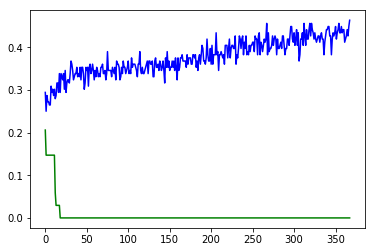

Starting epoch: 369 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


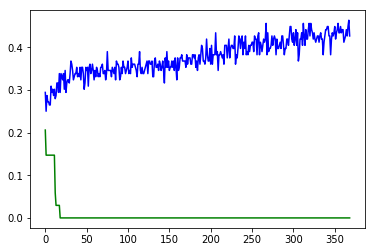

Starting epoch: 370 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


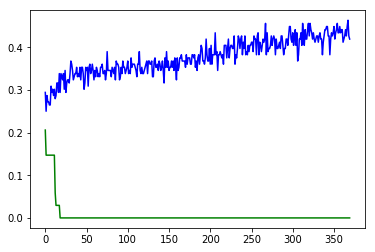

Starting epoch: 371 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


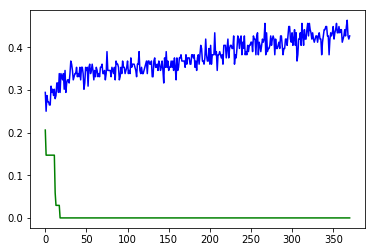

Starting epoch: 372 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


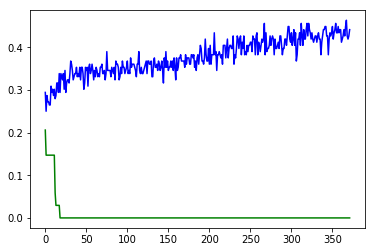

Starting epoch: 373 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


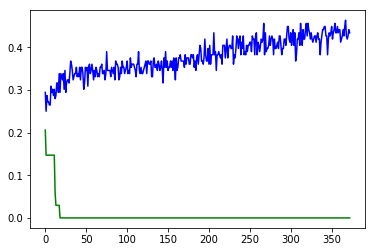

Starting epoch: 374 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


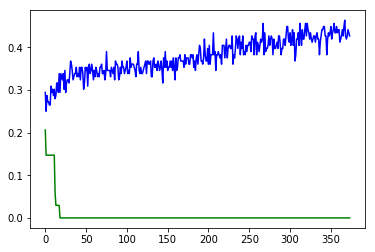

Starting epoch: 375 / 10000
training... done
Train Acc.: 0.404412
Val. Acc.: 0.000000


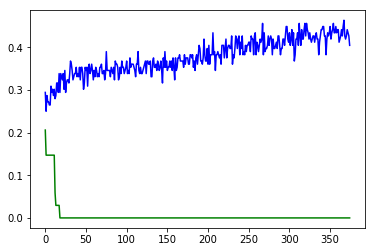

Starting epoch: 376 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


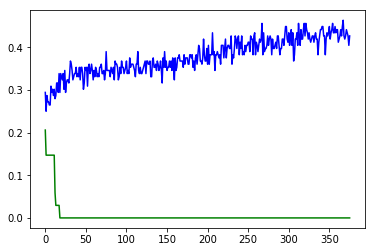

Starting epoch: 377 / 10000
training... done
Train Acc.: 0.448529
Val. Acc.: 0.000000


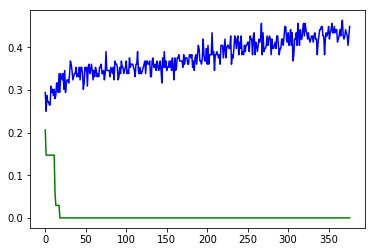

Starting epoch: 378 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


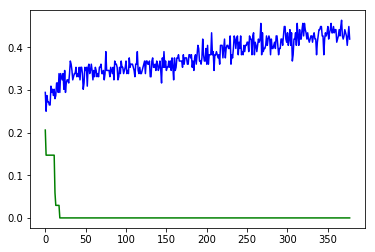

Starting epoch: 379 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


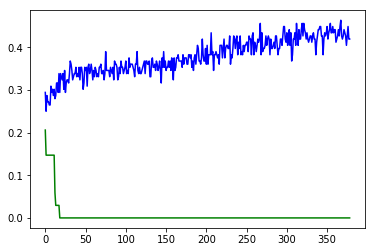

Starting epoch: 380 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


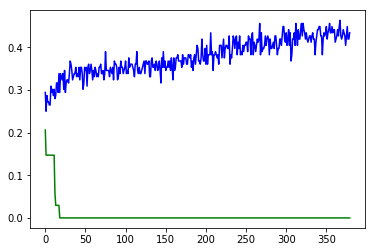

Starting epoch: 381 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


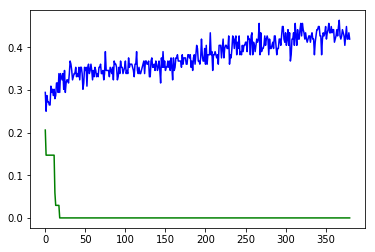

Starting epoch: 382 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


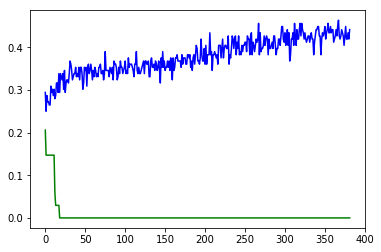

Starting epoch: 383 / 10000
training... done
Train Acc.: 0.448529
Val. Acc.: 0.000000


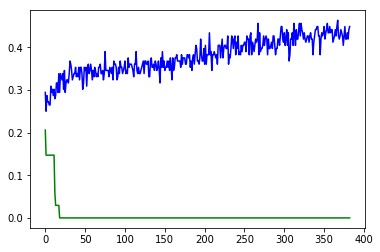

Starting epoch: 384 / 10000
training... done
Train Acc.: 0.463235
Val. Acc.: 0.000000


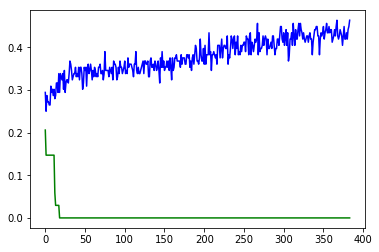

Starting epoch: 385 / 10000
training... done
Train Acc.: 0.375000
Val. Acc.: 0.000000


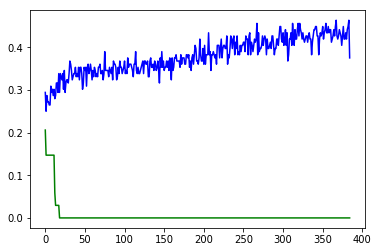

Starting epoch: 386 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


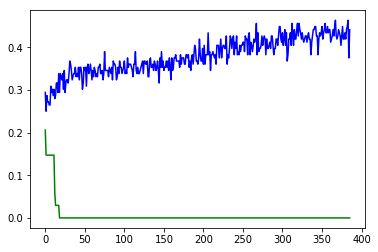

Starting epoch: 387 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


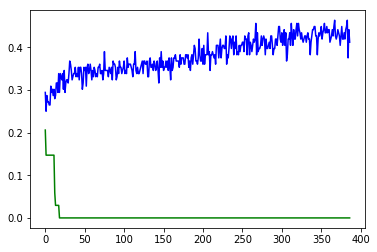

Starting epoch: 388 / 10000
training... done
Train Acc.: 0.455882
Val. Acc.: 0.000000


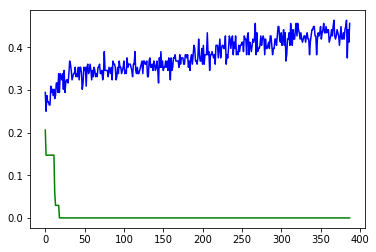

Starting epoch: 389 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


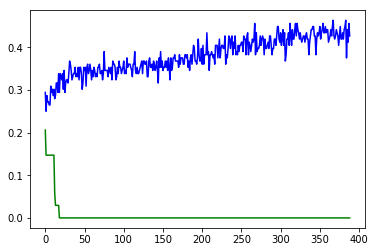

Starting epoch: 390 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


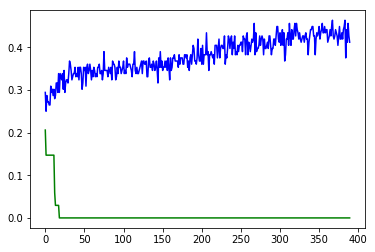

Starting epoch: 391 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


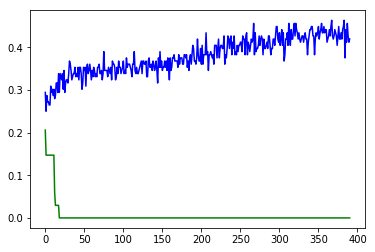

Starting epoch: 392 / 10000
training... done
Train Acc.: 0.455882
Val. Acc.: 0.000000


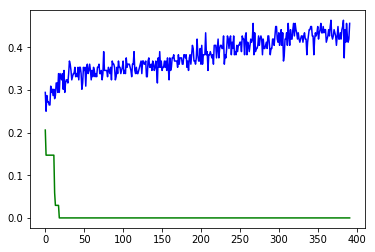

Starting epoch: 393 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


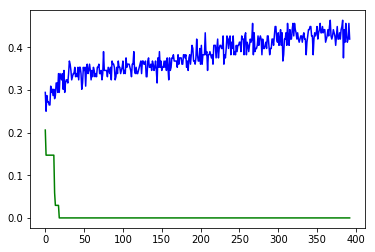

Starting epoch: 394 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


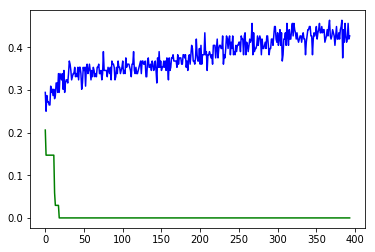

Starting epoch: 395 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


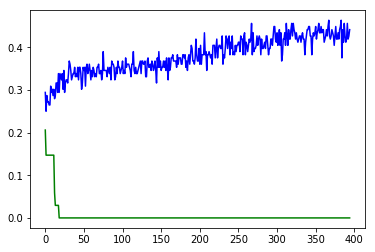

Starting epoch: 396 / 10000
training... done
Train Acc.: 0.441176
Val. Acc.: 0.000000


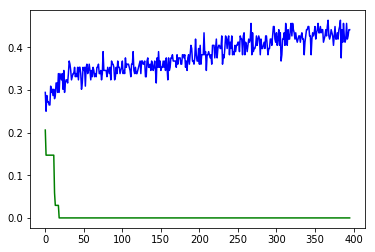

Starting epoch: 397 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


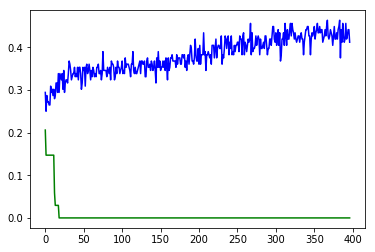

Starting epoch: 398 / 10000
training... done
Train Acc.: 0.426471
Val. Acc.: 0.000000


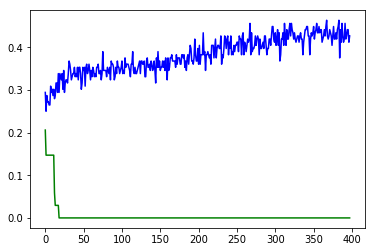

Starting epoch: 399 / 10000
training... done
Train Acc.: 0.433824
Val. Acc.: 0.000000


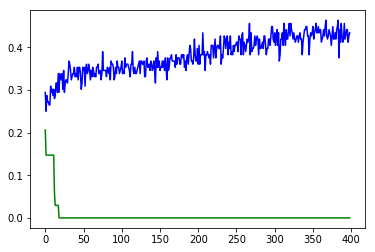

Starting epoch: 400 / 10000
training... done
Train Acc.: 0.397059
Val. Acc.: 0.000000


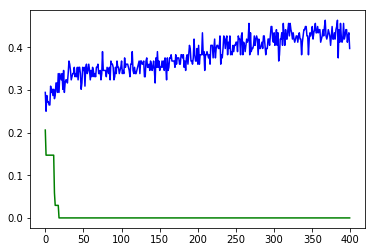

Starting epoch: 401 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


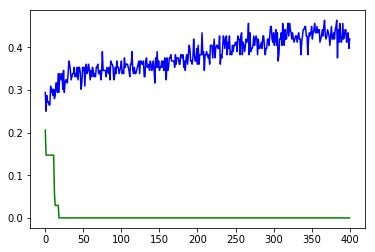

Starting epoch: 402 / 10000
training... done
Train Acc.: 0.470588
Val. Acc.: 0.000000


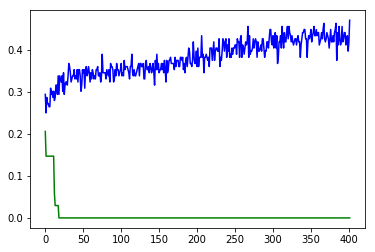

Starting epoch: 403 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


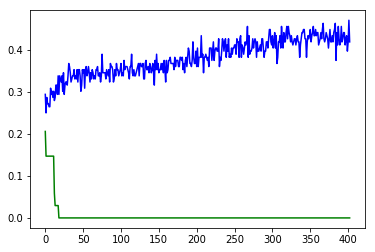

Starting epoch: 404 / 10000
training... done
Train Acc.: 0.477941
Val. Acc.: 0.000000


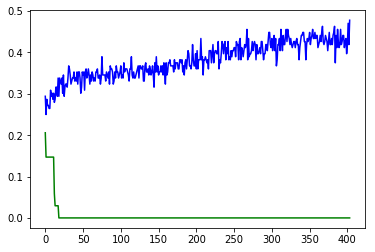

Starting epoch: 405 / 10000
training... done
Train Acc.: 0.448529
Val. Acc.: 0.000000


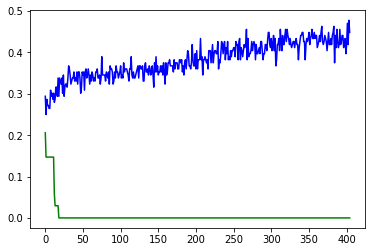

Starting epoch: 406 / 10000
training... done
Train Acc.: 0.477941
Val. Acc.: 0.000000


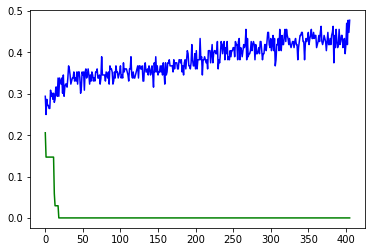

Starting epoch: 407 / 10000
training... done
Train Acc.: 0.411765
Val. Acc.: 0.000000


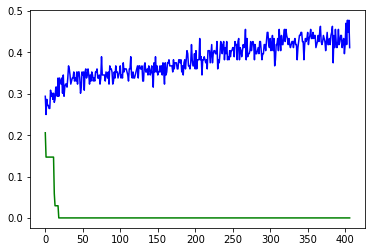

Starting epoch: 408 / 10000
training... done
Train Acc.: 0.419118
Val. Acc.: 0.000000


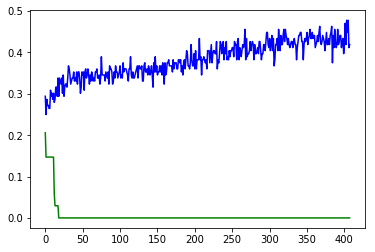

Starting epoch: 409 / 10000
training... done


KeyboardInterrupt: 

In [23]:
sess = tf.Session()
epochs = 10000
init_fn(sess)
sess.run(logits_init)
sess.run(auxlogits_init)

train_acc_all = []
val_acc_all = []

#begin training for the logit/auxlogit layers 
for ep in range(epochs):
    
    #starting training set iterator
    print 'Starting epoch: %d / %d' % (ep + 1, epochs)
    sess.run(train_init_op)
    print 'training...',
    while True: #run while iterator is non-empty
        try:
            _ = sess.run(auxlogit_train_op, {is_training:True})
            _ = sess.run(logit_train_op, {is_training:True})
        except tf.errors.OutOfRangeError:
            break
        
    print 'done'
    #train and val. acc
        
#     train_acc = get_accuracy(sess, predictions, labels, is_training, train_init_op)
#     val_acc = get_accuracy(sess, predictions, labels, is_training, val_init_op)

#     print_outputs(sess, output, labels, is_training, val_init_op)
#     print_outputs(sess, predictions, labels, is_training, val_init_op)
    
    train_acc = check_accuracy(sess, correct_predictions, is_training, train_init_op)
    val_acc = check_accuracy(sess, correct_predictions, is_training, val_init_op)
    
    
    print 'Train Acc.: %f' % train_acc
    print 'Val. Acc.: %f' % val_acc
        
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)
        
    #plotting
    t = range(len(train_acc_all))
    plt.plot(t, train_acc_all, 'b')
    plt.plot(t, val_acc_all, 'g')
    plt.show()

In [27]:
print_outputs(sess, predictions, labels, is_training, val_init_op)

output: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 3 2 3 3 2 0 0 3 0 2 0 3 0 3 3 0 3 2 0]
labels: 
[1 1]


In [ ]:
#full layer training
epochs = 50
for ep in range(epochs):
    
    #starting training set iterator
    print 'Starting epoch: %d / %d' % (ep + 1, epochs)
    sess.run(train_init_op)
    print 'training...',
    while True: #run while iterator is non-empty
        try:
            _ = sess.run(full_train_op, {is_training:True})
        except tf.errors.OutOfRangeError:
            break
        
    print 'done'
    #train and val. acc
        
#     train_acc = get_accuracy(sess, predictions, labels, is_training, train_init_op)
#     val_acc = get_accuracy(sess, predictions, labels, is_training, val_init_op)

#     print_outputs(sess, output, labels, is_training, val_init_op)
#     print_outputs(sess, predictions, labels, is_training, val_init_op)
    
    train_acc = check_accuracy(sess, correct_predictions, is_training, train_init_op)
    val_acc = check_accuracy(sess, correct_predictions, is_training, val_init_op)
    
    
    print 'Train Acc.: %f' % train_acc
    print 'Val. Acc.: %f' % val_acc
        
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)
        
    #plotting
    t = range(len(train_acc_all))
    plt.plot(t, train_acc_all, 'b')
    plt.plot(t, val_acc_all, 'g')
    plt.show()

Starting epoch: 1 / 50
training...